In [1]:
# Packages
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

# Control Variates for a GARCH Model

## Table of contents

### I - Presentation of the ZV principle of the article, in a general case
### II - Implementation of a Random Walk Metropolis Sampler
### III - Use of Control Variates
### IV - Expansion to Higher Order Polynomials
### V - Bonus: Linear Regression Validity
### VI - Conclusion

## I - Presentation of the ZV principle of the article, in a general case

Existing MCMC methods are already used to estimate the expectation of a function $f(x)$ with respect to a probability density $\pi(x)$, not necessarily normalized. This expectation is expressed by the following quantity:
$$ \mu_f = \frac{\int f(x)\pi(x)dx}{\int \pi(x)dx} $$

In practice, MCMCs estimate $\mu_f$ by taking the average of the $f(x_i)$ where $x_i$ are samples from a Markov chain that has $\pi$ as its stationary measure. This gives the following estimator:
$$ \hat{\mu}_f = \frac{1}{N}\sum_{i=1}^{N}f(x_i) $$

The innovative idea of the first proposed article is to reduce the variance of the MCMC estimator, $\hat{\mu}_f$, by replacing $f$ with a new function $\tilde{f}$ that satisfies $\hat{\mu}_f = \hat{\mu}_{\tilde{f}}$ under the measure $\pi$, but with a smaller variance $\mathrm{Var}(\hat{\mu}_f) < \mathrm{Var}(\hat{\mu}_{\tilde{f}})$.

To achieve this, a control function $\psi$ and a well-chosen operator $H$ are used, which allow us to write:
$$ \tilde{f}(x)=f(x)+\frac{H\psi(x)}{\sqrt{\pi(x)}} $$
The idea is thus to choose the right $H$ and the right function $\psi$ according to the use cases. Our project aims to adapt this method for a GARCH model.

The second article demonstrates how the method presented in the first can be implemented using the ordinary least squares estimator. By using control variables as covariates and $f(x)$ as the explained variable, we can find the optimal coefficients of the control variables and, consequently, use them in $\tilde{f}(x)$. For the case of the first-order polynomial *(to be discussed in III (Question 2))*, $\tilde{f}(x)$ can be written: $f(x) + a^T z$ where $z$ is the vector of covariates, and $a$ are the coefficients calculated by an OLS regression of $f(x)$ on $-z$.

This article also presents certain Lasso methods (LSLasso and LSLasso(X) in particular) to handle the case of higher degree polynomials. Indeed, this allows reducing the computation time by retaining only the most useful control variables and then applying OLS regressions only with these retained control variables. *We will discuss more on Lasso methods in IV (Question 3).*


## II - Implementation of a Random Walk Metropolis Sampler

*Follow the guidelines given in that experiment to implement a random walk Metropolis sampler that targets the posterior distribution of a GARCH model. For the data, you can use simulated data at first, and then look at the same type of real data (log-returns computed from exchange rates) in a second time.*


### Presentation of the Random Walk Metropolis-Hastings Sampler

The Metropolis-Hastings algorithm is a technique from the family of Markov Chain Monte Carlo (MCMC) methods. It facilitates the generation of a series of random samples from a probability distribution that is typically challenging to sample from directly. These samples can then be employed to approximate the distribution itself or to calculate integrals like expected values.

More precisely, for a given probability distribution $\pi$ defined over a set $\Omega$, the Metropolis-Hastings algorithm establishes a Markov chain. This chain is characterized by having $\pi$ as its stationary distribution, thereby enabling random sampling of elements from $\Omega$ as per the distribution $\pi$.

A notable aspect of the Metropolis-Hastings algorithm is that it requires knowledge of the distribution $\pi$ only up to a multiplicative constant. This is particularly advantageous as it circumvents the need to calculate the often intractable partition function of $\pi$, making the method highly useful in statistical physics.

As discussed in courses such as *Introduction to Stochastic Processes* and *Simulation and Monte Carlo Methods*, the algorithm's utility shines when calculating expectations. For instance, if we need to approximate the expectation $$\mathbb{E}_{X \sim \pi}[f] = \int_E f(x) \pi(x) dx$$ (assuming this integral exists), traditional simulation of independent and identically distributed variables $X_i$ from distribution $\pi$ would typically employ the law of large numbers: $$\frac{1}{n}\sum_{i=1}^n X_i \xrightarrow{p.s.}\int_E f(x) \pi(x) dx$$

However, if $\pi$ is complex, simulating variables from $\pi$ directly might be prohibitively costly. The Metropolis-Hastings method offers an alternative by simulating a positive, recurrent, irreducible Markov chain $(X_n)$ that converges to $\pi$ as its limit law. **According to the ergodic theorem for Markov chains:**

**Given $(X_n)$, a positive recurrent irreducible Markov chain with limit law $\pi$, transition matrix $P$, and initial distribution $\mu$, for all functions $f$ with $\int |f| d\pi < \infty$, we have:**
$$\frac{1}{n}\sum_{i=1}^n f(X_i) \to \int f d\pi \quad \text{almost surely as } n \to \infty$$

The Metropolis and Metropolis-Hastings algorithms simulate a Markov chain with a $\pi$-reversible transition matrix $P$, hence having $\pi$ as its invariant distribution. The primary verification left is to ensure the irreducibility of the chain; if it is irreducible and admits an invariant probability, it is positively recurrent.

The algorithm proceeds as follows:

Given a set $E = \mathbb{Z}^d$ for $d \geq 1$, consider the Metropolis-Hastings algorithm which involves the following components:

- **State Space and Proposal Distribution**: Let $q$ be a symmetric probability measure from which we can simulate a random variable. This distribution $q$ is used to propose movements in the state space, facilitating the exploration of the distribution $\pi$.

- **Initialization**: Begin with a fixed initial state $X_0$ in $E$.

For each iteration $n$:

1. **Generate Proposal**: Draw a candidate step $Z_n \sim q$, which is independent of all previously simulated variables. This step suggests a new position relative to the current state $X_n$.

2. **Random Uniform Draw**: Simultaneously, draw a random number $U_n \sim \mathcal{U}([0,1])$, also independent of previous draws. This value is used to decide whether to accept the proposed move.

3. **Acceptance Criterion**:
   - Define the acceptance probability as:
     $$
     \alpha(X_n, X_n + Z_n) = \min\left(1, \frac{\pi(X_n + Z_n)}{\pi(X_n)}\right)
     $$
   - Update the chain according to the acceptance probability:
     $$
     \begin{cases}
     X_{n+1} = X_n + Z_n & \text{if } U_n \leq \alpha(X_n, X_n + Z_n) \\
     X_{n+1} = X_n & \text{otherwise}
     \end{cases}
     $$

3. **Repetition**: Repeat the above step for a large number of iterations to form a chain whose distribution converges to $\pi$.

Key Features:
- **Flexibility in Proposal Distribution**: The choice of $q$ significantly impacts the efficiency of the algorithm. Ideally, $q$ should resemble $\pi$ as closely as possible to maximize the acceptance rate.
- **Convergence Properties**: Under broad conditions, the Markov chain generated by the Metropolis-Hastings algorithm is ergodic, meaning that it converges to the stationary distribution $\pi$, regardless of the starting point.
- **Multiplicative Constant**: A practical advantage of Metropolis-Hastings is its reliance only on the ratio of probabilities, which means the algorithm does not require knowledge of the normalizing constant of $\pi$.


### The context of the problem: Bayesian Estimation in a Normal-GARCH(1,1) Model

The Normal-GARCH(1,1) model provides a statistical framework for analyzing financial time series that exhibit time-varying volatility and clustering effects. In our specific example, we utilize Bayesian methods to estimate parameters under the assumption that the returns are conditionally normally distributed with a predictable variance.

**Returns Distribution**: The returns $r(t)$ given the information up to time $t-1$, denoted $F_{t-1}$, are assumed to follow a normal distribution:
  $$
  r(t) | F_t \sim \mathcal{N}(0, h_t)
  $$
  where $h_t$ is a predictable process:
  $$
  h_t = \omega_1 + \omega_3 h_{t-1} + \omega_2 r_{t-1}^2
  $$
  with constraints $\omega_1 > 0$, $\omega_2 \geq 0$, and $\omega_3 \geq 0$ to ensure positivity of the variance.

**Truncated Normal Priors**: Given the constraints on the parameters, the prior distributions for $\omega_1$, $\omega_2$, and $\omega_3$ are independent truncated normal distributions:
  $$
  f(x | \mu, \sigma, a) = \begin{cases} 
  \frac{1}{Z} \phi\left(\frac{x-\mu}{\sigma}\right) & \text{if } x \geq a \\
  0 & \text{if } x < a 
  \end{cases}
  $$
  where $\phi$ denotes the standard normal probability density function and $Z$ is a normalization constant.

**Likelihood of the GARCH Model**: The likelihood for observing a series of returns given the parameters is expressed as the product of individual normal densities:
  $$
  l(\omega_1, \omega_2, \omega_3 | r) \propto \left(\prod_{t=1}^T h_t\right)^{-\frac{1}{2}} \exp\left(-\frac{r_t^2}{2h_t}\right)
  $$
  where $T$ is the total number of observations.

**Log-Likelihood Computation**: Simplifying computations in Bayesian estimation, the log-likelihood is given by:
  $$
  \log l(\omega_1, \omega_2, \omega_3 \mid r) = -\frac{1}{2} \sum_{t=1}^T \left( \log h_t + \frac{r_t^2}{h_t}\right)
  $$

**Combining Prior and Likelihood**: The **posterior distribution**, representing the updated beliefs about the parameters after observing the returns, is proportional to the product of the likelihood and the prior:
  $$
  \pi(\omega_1, \omega_2, \omega_3 | r) \propto \text{prior} \times \text{likelihood}
  $$
  Specifically, it incorporates both the likelihood of the observed returns under the GARCH model and the truncated normal priors:
  $$
  \pi(\omega_1, \omega_2, \omega_3 | r) \propto \exp\left(-0.5 \left(\frac{\sigma^2(\omega_1)}{\omega_1^2} + \frac{\sigma^2(\omega_2)}{\omega_2^2} + \frac{\sigma^2(\omega_3)}{\omega_3^2}\right)\right) \left(\prod_{t=1}^T h_t\right)^{-\frac{1}{2}} \exp\left(-\frac{r_t^2}{2h_t}\right)
  $$

**Simulate GARCH Process**: For a given parameter set $\omega = (\omega_1, \omega_2, \omega_3)$ and length $T$, we initialize $h_0 = \frac{\omega_1}{1-\omega_2-\omega_3}$, as seen in the literature, and $r_0 \sim \mathcal{N}(0, h_0)$. For each subsequent time $t$, $h_t$ and $r_t$ are updated based on the GARCH(1,1) formula, providing a series of returns and conditional variances.

This Bayesian framework provides a robust method for parameter estimation in financial models, allowing for the incorporation of prior knowledge and the flexibility to handle complex stochastic behaviors in financial time series.


### Implementation

In [2]:
def simulate_garch(T, omega_1, omega_2, omega_3):
    np.random.seed(111)  # For reproducibility
    r = np.zeros(T)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3)
    r[0] = np.random.normal(0, np.sqrt(abs(h[0]))) # abs

    
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        r[t] = np.random.normal(0, np.sqrt(abs(h[t]))) #abs
        
    return r, h


In [3]:
def log_likelihood(r, omega_1, omega_2, omega_3):
    T = len(r)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3) if (omega_2 + omega_3) < 1 else 100000  # large number for stability
    
    log_lik = 0
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        log_lik -= 0.5 * (np.log(abs(h[t])) + r[t]**2 / h[t]) # abs
    
    return log_lik

def log_posterior(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    log_prior = -0.5 * (omega_1**2 / sigma_1**2 + omega_2**2 / sigma_2**2 + omega_3**2 / sigma_3**2)
    return log_likelihood(r, omega_1, omega_2, omega_3) + log_prior

def proposal(omega_old, sigma_proposal ): # function used in the MH algorithm that will "propose" the new parameter (new omega here)
    # omega_old is the list containing the old omegas, we will use a normal probability distribution to determine the new ones
    omega = np.array([0.0,0.0,0.0])
    omega[0] = np.random.normal(loc= omega_old[0], scale = sigma_proposal)
    omega[1] = np.random.normal(loc= omega_old[1], scale = sigma_proposal)
    omega[2] = np.random.normal(loc= omega_old[2], scale = sigma_proposal)

    return omega

def metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega):
    # Let's initialize our variable
    acceptation = np.array([False]*iterations) # we will through the iterations accept or not the change of value of omega
    omega = initial_omega
    omega_sampling = [omega]
    # Let's apply the algorithm trough all the iterations
    for t in range(iterations):
        # We propose a candidate for omegas
        omega_new = proposal(omega, sigma_proposal)
        # We calculate the acceptance alpha which is ratio of the prior of the new omega over the old omega
        alpha = log_posterior(returns,omega_new[0],omega_new[1],omega_new[2],sigma_omega[0],sigma_omega[1],sigma_omega[2]) - log_posterior(returns,omega[0],omega[1],omega[2],sigma_omega[0],sigma_omega[1],sigma_omega[2])
        # We compare alpha with 1 and an uniform random number
        u = np.random.uniform(0,1)
        if alpha > 0:  # reminder that alpha is a log here so we don't compare with 1 but with 0
            acceptation[t] = True
            omega = omega_new
        if alpha < 0:
            if alpha > np.log(u): # we compare to log u and not u
                acceptation[t]= False
                omega = omega_new # we take the new omega
        omega_sampling.append(omega)
    acceptance_rate = np.sum(acceptation)/len(acceptation)*100
    return acceptance_rate, omega_sampling

### Evaluation Strategy for the Metropolis-Hastings Implementations

To validate the efficacy and accuracy of our statistical methods and implementations using the Metropolis-Hastings algorithm within a GARCH model framework, we have designed a series of tests and verifications:

#### 1. Comparison of Estimated and True Parameters

- **Objective**: Assess the accuracy of the Metropolis-Hastings algorithm in estimating the parameters of the GARCH model.
- **Method**: We will initialize our simulations with a set of known parameters (`initial_omega`) that define the GARCH model and generate synthetic return data. After applying the Metropolis-Hastings algorithm, we will compare the estimated parameters (`metropolis_omega`) with the `initial_omega`. The closer these parameters are, the more accurate our estimation method is deemed to be.

#### 2. Variance Reduction through the Modified Estimator

- **Objective**: Determine whether the modified estimator function $\tilde{f}$ can effectively reduce the variance of the estimators without altering their expected values.
- **Method**: We will compute the variance of the standard estimator and compare it with the variance of the modified estimator $\tilde{f}$. The goal is to confirm that $\tilde{f}$ reduces the variance while maintaining the same expected value, enhancing the efficiency of our estimations.

#### 3. Testing the Unbiasedness of Estimators

- **Objective**: Verify the unbiasedness of our estimators, a property that has been theoretically established in the scholarly literature.
- **Method**: This test involves repeated sampling and estimation using our Metropolis-Hastings-based approach to calculate an empirical distribution of the estimator. We will then statistically test whether this distribution centers around the true parameter values, thus confirming unbiasedness. The absence of bias is crucial for ensuring that the estimators reliably reflect the true parameters of the model across different samples.


### Simulated Data

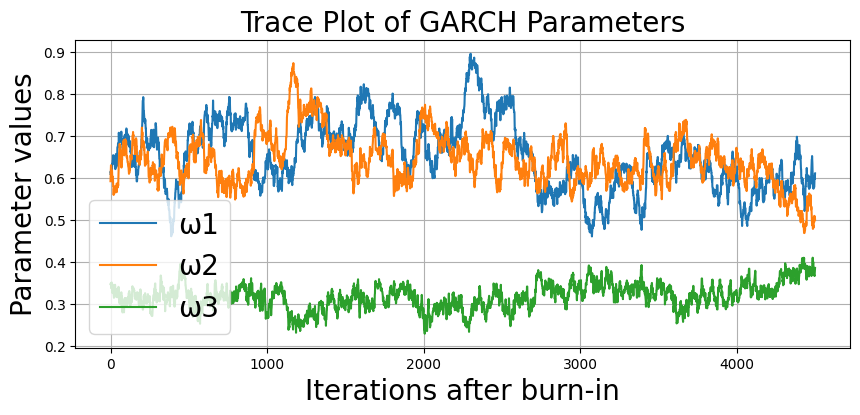

In [4]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors 

# Simulate data
returns, _ = simulate_garch(1000, *true_omega)

# Metropolis-Hastings settings
iterations = 5000
burn_in = 500
sigma_proposal = 0.01 

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We plot the parameter trajectories
plt.figure(figsize=(10, 4))
plt.plot(w1_samples[burn_in:], label='ω1')
plt.plot(w2_samples[burn_in:], label='ω2')
plt.plot(w3_samples[burn_in:], label='ω3')
plt.legend(fontsize=20)
plt.xlabel('Iterations after burn-in', fontsize=20)
plt.ylabel('Parameter values', fontsize=20)
plt.title('Trace Plot of GARCH Parameters', fontsize=20)
plt.grid(True)
plt.show()

As previously discussed, we expect that 
$$\frac{1}{n}\sum_{i=1}^n f(X_i) \to \int f \, d\pi \quad \text{almost surely as } n \to \infty.$$ 
In this instance, we define the identity function as $f$: $f([\omega_1,\omega_2,\omega_3]) = [\omega_1,\omega_2,\omega_3]$. Consequently, we will verify whether the empirical means of these three sequences approach the actual values of the parameters $\omega_1$, $\omega_2$, and $\omega_3$.

In [5]:
# Computing the average values post burn-in
expected_w1 = np.average(w1_samples[burn_in:])
expected_w2 = np.average(w2_samples[burn_in:])
expected_w3 = np.average(w3_samples[burn_in:])

# Display the calculated mean values
print("Calculated Mean Values:")
print(f"Expected ω1: {expected_w1}")
print(f"Expected ω2: {expected_w2}")
print(f"Expected ω3: {expected_w3}")

Calculated Mean Values:
Expected ω1: 0.653192548458086
Expected ω2: 0.6431735604052816
Expected ω3: 0.3178397911342751


Our $\omega_1,\omega_2,\omega_3$ implemented in the garch_simulation were : $[0.6, 0.7, 0.3]$, therefore we have almost the same figures which means that our algorithm works well.

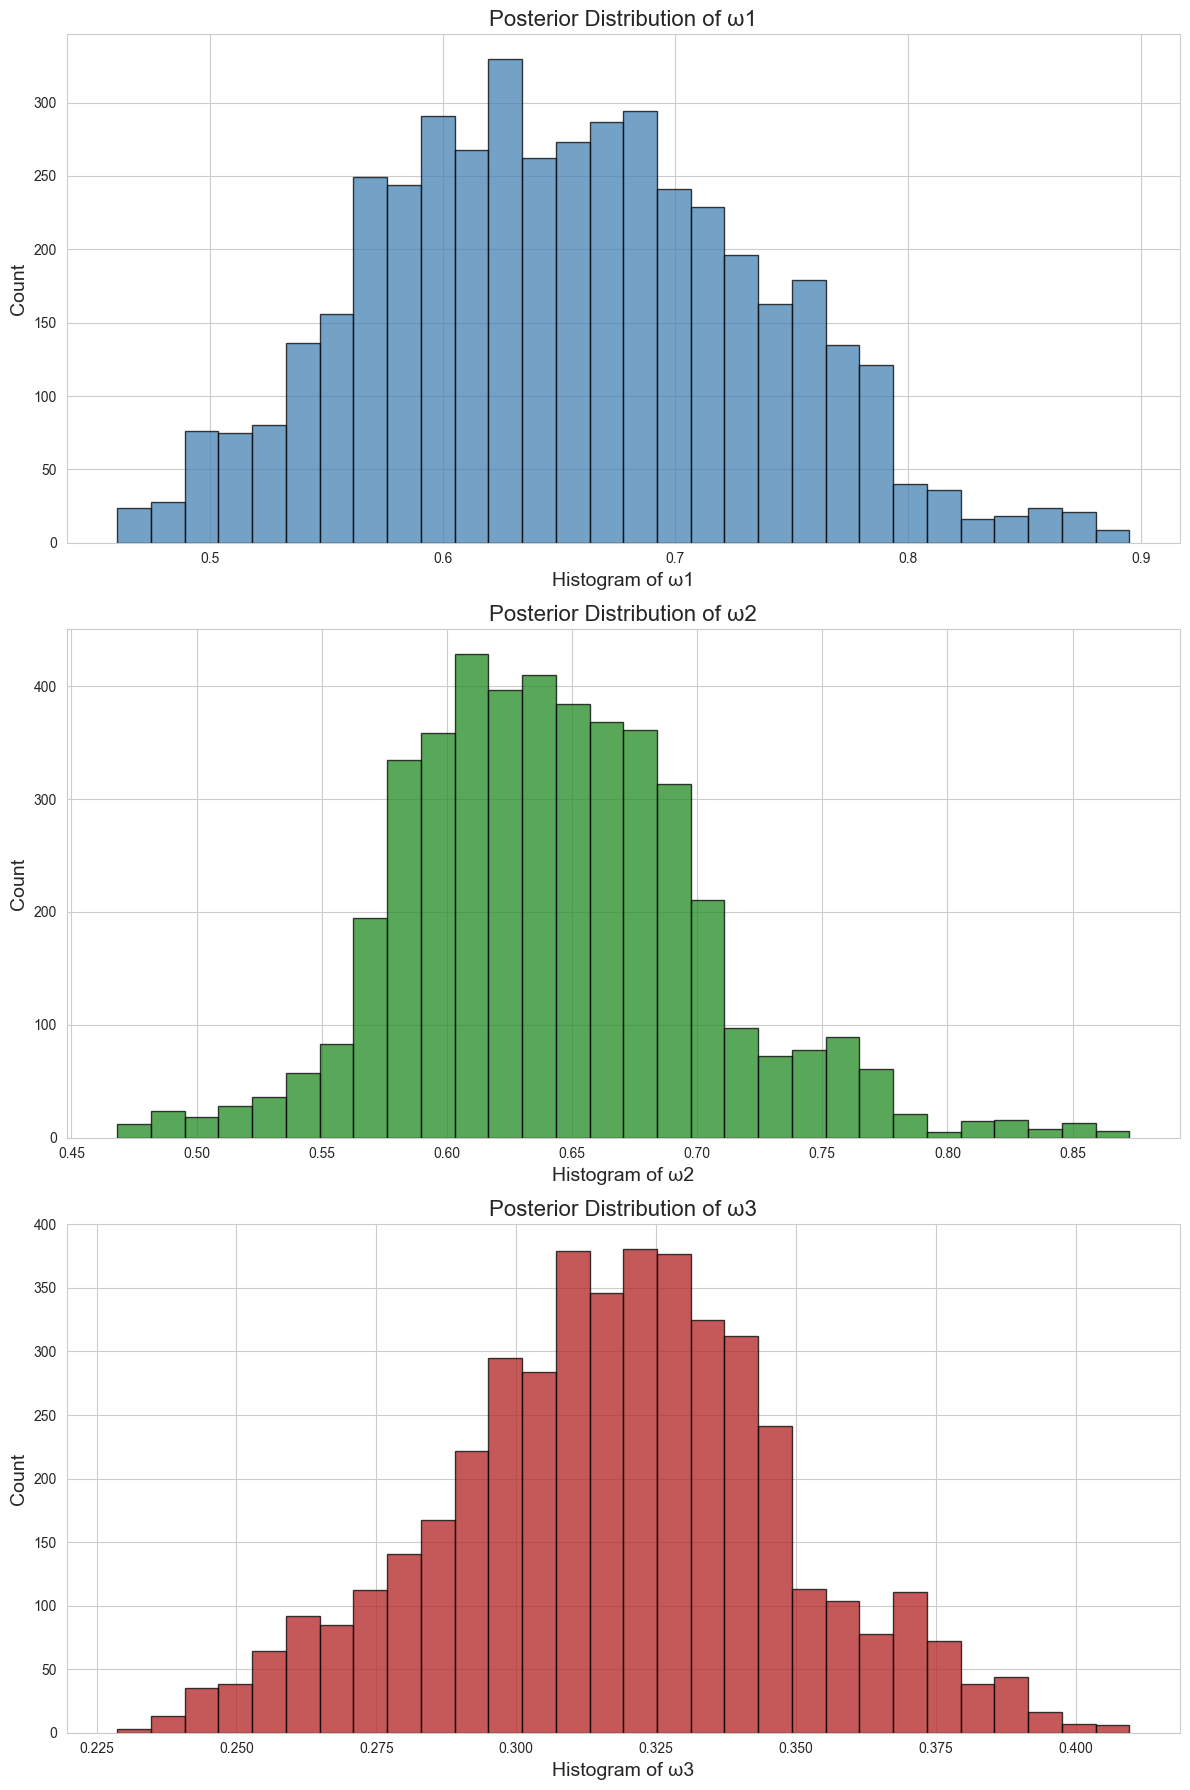

In [6]:
# Apply a seaborn style to enhance aesthetics
sns.set_style("whitegrid")

fig, axs = plt.subplots(3, figsize=(12, 18))

# Function to plot a histogram with matplotlib, with enhanced presentation
def custom_hist(data, bins, color, label, ax):
    counts, edges, _ = ax.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.75)
    ax.set_xlabel(label, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    return counts, edges

# Plot histograms with detailed customization
_, edges1 = custom_hist(w1_samples[burn_in:], 30, 'steelblue', 'Histogram of ω1', axs[0])
axs[0].set_title('Posterior Distribution of ω1', fontsize=16)

_, edges2 = custom_hist(w2_samples[burn_in:], 30, 'forestgreen', 'Histogram of ω2', axs[1])
axs[1].set_title('Posterior Distribution of ω2', fontsize=16)

_, edges3 = custom_hist(w3_samples[burn_in:], 30, 'firebrick', 'Histogram of ω3', axs[2])
axs[2].set_title('Posterior Distribution of ω3', fontsize=16)

# Fine-tuning the plot layout
plt.tight_layout()
plt.show()

We can see that these histograms of the posterior distribution of $\omega_1,\omega_2,\omega_3$ are almost histograms from normal distribution. However, they are not perfectly centered with the empirical expected value of omega but they are indeed near of them. We could also see it with boxplot.

We are now going to develop a function that will iterate the Metropolis-Hastings algorithm. This iterative approach is designed to facilitate statistical testing and study the distributions of the omega parameters. This function will play a crucial role in evaluating the robustness and statistical properties of our parameter estimates, providing insights into the effectiveness of the Metropolis-Hastings method in capturing the dynamics of financial time series.

In [7]:
def mean_metropolis_algorithm(iterations1):
    expected_w1_list = []
    expected_w2_list = []
    expected_w3_list = []
    for i in range(iterations1):
        results = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

        # Check if results structure is as expected
        if not isinstance(results, tuple) or len(results) < 2:
            raise ValueError("The results from the Metropolis-Hasting algorithm do not match the expected format.")

        omega_samples = results[1]  # Assuming the second item is the list of omega samples

        # Prepare lists to hold the current iteration values for w1, w2, w3
        w1_samples = []
        w2_samples = []
        w3_samples = []

        # Extract samples depending on whether they are scalar or array-like
        for sample in omega_samples:
            w1_samples.append(sample[0])
            w2_samples.append(sample[1])
            w3_samples.append(sample[2])

        # Calculate means after burn-in period
        w1_expected = np.mean(w1_samples[burn_in:])
        w2_expected = np.mean(w2_samples[burn_in:])
        w3_expected = np.mean(w3_samples[burn_in:])
        
        expected_w1_list.append(w1_expected)
        expected_w2_list.append(w2_expected)
        expected_w3_list.append(w3_expected)

        
        
    return [expected_w1_list, expected_w2_list, expected_w3_list]

In [8]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns, _ = simulate_garch(900, *true_omega)

# Metropolis-Hastings settings
iterations = 3000 # less iterations than before
burn_in = 300 # smaller burn_in too
sigma_proposal = 0.01


In [9]:
mean_met_alg = mean_metropolis_algorithm(5)

As previously discussed, we are now set to evaluate whether the modified estimator function $\tilde{f}$ can successfully reduce the variance of our estimators without altering their expected values. By utilizing the outputs from the mean Metropolis algorithm, we will be able to measure the variance of our estimators and determine the efficacy of $\tilde{f}$ in achieving variance reduction. This analysis is crucial for enhancing the precision and reliability of our statistical estimations.

In [10]:
def variance_estimators(mean_met_alg):
    return statistics.variance(mean_met_alg[0]), statistics.variance(mean_met_alg[1]), statistics.variance(mean_met_alg[2])

So the variance without the method used in the article (we will see the vairance reduction in the next question) is:

In [11]:
print("The variance without the method used in the article is:")
print(f"Variance de ω1,w2,w3 : {variance_estimators(mean_met_alg)}")

The variance without the method used in the article is:
Variance de ω1,w2,w3 : (0.0008699321234375044, 0.00035026660528524625, 9.285919050176603e-05)


Now, let's check the unbiasedness of our estimators that has been proven in one of the article. We will see that there is still some bias but it is very small and it may be explicated by the few numbers of iterations of the metropolis_hasting_algorithm, so like it was said in the paper, there is the unbiasedness of the estimators.


In [12]:
def bias_estimators(mean_met_alg):
    return statistics.mean(mean_met_alg[0]) - true_omega[0], statistics.mean(mean_met_alg[1]) - true_omega[1], statistics.mean(mean_met_alg[2]) - true_omega[2]

print(f"The bias of the estimators are : {bias_estimators(mean_met_alg)}")

The bias of the estimators are : (0.10718685176151099, -0.04499540821504722, 0.007141588701138957)


To end this part we can finally check the mean squared error of the estimators:

In [13]:
mse = {}

# We calculate the MSE for each parameter
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg[i-1]])

print(mse)

{1: 0.012184966889294126, 2: 0.002304800044666934, 3: 0.00012528964157764843}


### Real Data

We are transitioning from theoretical simulations to practical applications by testing our methods on real data. We focus on computing log-returns from exchange rates, specifically between the Euro and the GBP.

For this purpose, we retrieve data from the ECB (European Central Bank) database using the "DEXUSEU" series code, which represents the daily exchange rate between the US dollar and the Euro. This code allows us to directly query the relevant data for our analysis.


In [14]:
from lxml import etree
import requests
import pandas as pd

def fetch_ecb_data(series_id, start_date, end_date):
    # Define the URL template for accessing ECB data
    url = f"https://sdw-wsrest.ecb.europa.eu/service/data/EXR/D.{series_id}.EUR.SP00.A"

    # Set up headers to specify the desired response format as 'generic' XML
    headers = {
        'Accept': 'text/xml'
    }
    params = {
        'startPeriod': start_date,
        'endPeriod': end_date
    }
    response = requests.get(url, headers=headers, params=params)

    # We parse the XML response
    root = etree.fromstring(response.content)
    ns = {'ns': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
          'common': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
          'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}

    # Then we extract data points
    data = []
    for series in root.xpath('.//generic:Series', namespaces=ns):
        for obs in series.xpath('.//generic:Obs', namespaces=ns):
            time = obs.find('.//generic:ObsDimension', namespaces=ns).get('value')
            value = obs.find('.//generic:ObsValue', namespaces=ns).get('value')
            data.append({'Date': time, 'Rate': value})

    # Convert list of dictionaries into a DataFrame
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df['rate'] = pd.to_numeric(df['Rate'], errors='coerce')
    return df

/Users/antoine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [15]:
# We will use EUR to GBP exchanges rates on the year 2019 to 2022:
df = fetch_ecb_data('GBP', '2019-01-01', '2022-12-31')
df.head()

,Date,Rate,rate
0,2019-01-02,0.90165,0.90165
1,2019-01-03,0.90312,0.90312
2,2019-01-04,0.89988,0.89988
3,2019-01-07,0.8972,0.89720
4,2019-01-08,0.89743,0.89743


In [16]:
df["rate"] = (df["rate"] - df["rate"].shift(1)) / df["rate"].shift(1)
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['rate'])
df['rate'] = df['rate'].interpolate() # for the missing values
rates = df["rate"].to_numpy()*100
rates

array([ 0.16303444, -0.35875631, -0.29781749, ..., -0.31132193,
        0.55758704,  0.16262183])

Following the methodology established in the first part of our study using simulated data, we now extend our analysis to real-world data. 
Before doing this, we fit a GARCH model to the exchange rate data retrieved in our previous step. This allows us to observe the model's behavior and effectiveness in capturing the financial time series' volatility characteristics under real market conditions.

In [17]:
import arch
real_garch = arch.arch_model(rates, vol = 'GARCH', p=1, q=1) # GARCH(1,1)
real_garch = real_garch.fit()
print(real_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 468895.5390594251
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1630995142.1371253
Iteration:      3,   Func. Count:     23,   Neg. LLF: 662.8133416047322
Iteration:      4,   Func. Count:     30,   Neg. LLF: 664.4964495261827
Iteration:      5,   Func. Count:     36,   Neg. LLF: 613.0055477032379
Iteration:      6,   Func. Count:     41,   Neg. LLF: 613.003737194661
Iteration:      7,   Func. Count:     46,   Neg. LLF: 613.0008022334438
Iteration:      8,   Func. Count:     51,   Neg. LLF: 613.0007752881918
Iteration:      9,   Func. Count:     56,   Neg. LLF: 613.0007707085082
Iteration:     10,   Func. Count:     60,   Neg. LLF: 613.0007707085272
Optimization terminated successfully    (Exit mode 0)
            Current function value: 613.0007707085082
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results               

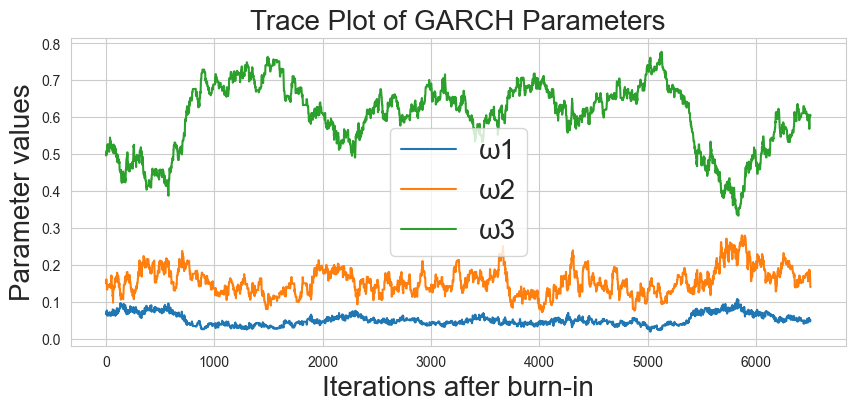

In [18]:
# Now we use our metropolis_hasting_algorithm with our real data, we use the same parameters as for the simulated data : ( the same thing as for simulated data)

# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.0368,0.6921,0.1308] # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns = rates

# Metropolis-Hastings settings
iterations = 7000
burn_in = 500
sigma_proposal = 0.01

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We plot the parameter trajectories
plt.figure(figsize=(10, 4))
plt.plot(w1_samples[burn_in:], label='ω1')
plt.plot(w2_samples[burn_in:], label='ω2')
plt.plot(w3_samples[burn_in:], label='ω3')
plt.legend(fontsize=20)
plt.xlabel('Iterations after burn-in', fontsize=20)
plt.ylabel('Parameter values', fontsize=20)
plt.title('Trace Plot of GARCH Parameters', fontsize=20)
plt.grid(True)
plt.show()


In [19]:
mean_met_alg2 = mean_metropolis_algorithm(5)

In [20]:
# Let's reuse the function we have implemented for the simulated datas :

# Variance
print(f"Variance de ω1,w2,w3 : {variance_estimators(mean_met_alg2)}")
# Bias
print(f"The bias of the estimators are : {bias_estimators(mean_met_alg2)}")
# MSE
mse = {}
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg2[i-1]])
print(mse)


Variance de ω1,w2,w3 : (0.0007459593971068197, 0.0010028572745971488, 0.005601768095494534)
The bias of the estimators are : (-0.012311746399977175, -0.5571273940970953, 0.5348650937079967)
{1: 0.0007483466171028066, 2: 0.3111932190730978, 3: 0.2905620829436598}


We have very small variance, bias and mse as in with simulated datas !

In [21]:
# We can also check directly the mean of the estimators rather than the bias :

def mean_estimators(mean_met_alg2):
    return statistics.mean(mean_met_alg2[0]), statistics.mean(mean_met_alg2[1]), statistics.mean(mean_met_alg2[2])

print(f"The mean value of the estimators are : {mean_estimators(mean_met_alg2)}") # Recall : true_omega_1 = 0. , true_omega_2 = 0.4, true_omega_3 = 0.9

The mean value of the estimators are : (0.024488253600022825, 0.13497260590290475, 0.6656650937079968)


We can see that we have some very few difference between the expected empirical means and the true values. With real datas of EUR to GBP on 2019-2022, it works less than with our simulated datas.

## III - Use of Control Variates

*Consider the control variates proposed in the paper (Equation (8), and in particular the versions based on a first-order polynomial, i.e., $f(x) + a^T z$). Explain how you can use these control variates in this setting by doing a linear regression.*


The primary objective explored in this segment of the research paper is to minimize the variance of the estimators for the parameters $\omega_1$, $\omega_2$, and $\omega_3$. This is achieved by employing specific functions $H$ and $\psi$, which are used to construct the re-normalized function:

$$\tilde{f}(x) = f(x) + \frac{H\psi(x)}{\sqrt{\pi(x)}}$$

where $\pi$ denotes the posterior distribution function.

### Methodology

#### Hamiltonian and Trial Function
The Schrödinger-type Hamiltonian $H$, used in this context, is defined as:

\begin{equation}
    Hf = -2\Delta f + V(x)f
\end{equation}

The trial function $\psi(x)$ is set as $\psi(x) = P(x) * \pi(x)$, where $P$ is a polynomial. Given this setup, the re-normalized function $\tilde{f}(x)$ simplifies to:

$$\tilde{f}(x) = f(x) - \frac{1}{2} \Delta P(x) + \nabla P(x) \cdot z$$

Here, $z = -\frac{1}{2} \nabla \ln \pi(x)$ acts as the control variates, $\nabla$ is the gradient operator, and $\Delta = \sum_{i=1}^d\frac{\partial^2 }{\partial x_i^2}$ represents the Laplacian.

#### Application in a First Order Polynomial Case
For a first order polynomial $P(x) = \sum_{i=1}^3 a_i x_i$, the Laplacian $\Delta P(x)$ equals zero, simplifying our formula to:

$$\tilde{f}(x) = f(x) + a^T z$$

where $z$ is the vector of the three covariates.

### Estimation Strategy

#### Linear Regression for Variance Reduction
Our aim is to find a coefficient vector $a$ that minimizes the variance of $\tilde{f}(x)$. This is done through an ordinary least squares (OLS) regression of $f(x)$ on $-z$, which helps empirically determine:

$$\alpha = \arg\min_a \left(\sum_{i=1}^n (f(X_i) + a^T z_i)^2\right)$$

This effectively approximates the empirical expected value of $\tilde{f}(x)$, constructed to maintain the same expected value as $f(x)$, $\mu_f = \mu_{\tilde{f}}$.

#### Variance Analysis

$$V(\widetilde{f}) = V(f+a^Tz) = \mathbb{E}[(f+a^Tz)^2] - \mathbb{E}[(f+a^Tz)]^2 = \mathbb{E}[(f+a^Tz)^2] - \mathbb{E}[f]^2 \quad$$ 
The last equality comes from the fact that by construction $\mathbb{E}[\widetilde{f}] = \mathbb{E}[f] $.

We showed that $\mathbb{E}[f]^2$ does not depend by $a$. 
So minimizing $V(\widetilde{f})$ is equivalent to minimizing $\mathbb{E}[(f+a^Tz)^2] = \mathbb{E}[(f- a^T(-z))^2] $.  
We recognize the minimization problem of a linear regression of $f$ on $-z$ so we know that $a = \mathbb{E}[zz^T]^{-1}\mathbb{E}[zf]$ as the article says.

If $ \mathbb{E}[f^2]<∞$ and $\mathbb{E}[[ || -z || ]^2]<∞$ and $\mathbb{E}[zz^T]$ is a non singular matrix then the OLS estimator is consistent (if observations are IID). So we will estimate $a$ by $â$ the OLS estimator, given by:
$$â = (\sum_{t=1}^{T}z_tz_t^T)^{-1}(\sum_{t=1}^{T}-z_tf_t)$$



# Implementation

### Computation of the control variates

First of all, we need to compute the three control variates, defined by $z=-\frac{1}{2} \nabla \ln \pi$.

The gradient of the log-posterior $\ln \pi$ with respect to each parameter $ \omega_i $ involves contributions from the prior and the likelihood:
$$
\frac{\partial \ln \pi}{\partial \omega_i} = -\frac{\omega_i}{\sigma^2(\omega_i)} - \frac{1}{2} \sum_{t=1}^T \left( \frac{1}{h_t} \frac{\partial h_t}{\partial \omega_i} - \frac{r_t^2}{h_t^2} \frac{\partial h_t}{\partial \omega_i} \right), \quad i = 1, 2, 3
$$

The derivatives of the volatility equation $ h_t $ with respect to the parameters are defined as:
$$
\frac{\partial h_t}{\partial \omega_1} = \frac{1 - \omega_3^{t-1}}{1 - \omega_3} \quad \text{(assuming $ \omega_3 \neq 1 $)}
$$

$$
\frac{\partial h_t}{\partial \omega_2} = r_{t-1}^2 + \omega_3 \frac{\partial h_{t-1}}{\partial \omega_2} \quad \text{for } t > 1 \text{, and 0 else}
$$

$$
\frac{\partial h_t}{\partial \omega_3} = h_{t-1} + \omega_3 \frac{\partial h_{t-1}}{\partial \omega_3} \quad \text{for } t > 1 \text{, and 0 else}
$$


-------

**Error in the article ? Should be $\omega_3^t$ ?**

*Objective:*
Compute the derivative of $h_t= \omega_1 + \omega_2 r_{t-1}^2 + \omega_3 h_{t-1}$ with respect to $\omega_1$, $\frac{\partial h_t}{\partial \omega_1}$.

*Initial Setup:*
Since $\omega_1$ is a constant addition at each time step $t$,
$ \frac{\partial \omega_1}{\partial \omega_1} = 1 $
and since $r_{t-1}^2$ does not depend on $\omega_1$,
$ \frac{\partial (r_{t-1}^2)}{\partial \omega_1} = 0 $

*Recursive Derivation:*
Starting from the base case at $t=0$, assuming $h_0$ is either non-dependent on $\omega_1$ or set by an initial condition (making it a constant):
$ h_1 = \omega_1 + \omega_2 r_0^2 + \omega_3 h_0 $ gives 
$ \frac{\partial h_1}{\partial \omega_1} = 1 $

At $t=2$:
$ h_2 = \omega_1 + \omega_2 r_1^2 + \omega_3 h_1 $ gives
$ \frac{\partial h_2}{\partial \omega_1} = 1 + \omega_3 \cdot \frac{\partial h_1}{\partial \omega_1} = 1 + \omega_3 $

Proceeding recursively,
$ h_3 = \omega_1 + \omega_2 r_2^2 + \omega_3 h_2 $ gives 
$ \frac{\partial h_3}{\partial \omega_1} = 1 + \omega_3 \cdot \frac{\partial h_2}{\partial \omega_1} = 1 + \omega_3 + \omega_3^2 $

$$\vdots$$

$ \frac{\partial h_t}{\partial \omega_1} = 1 + \omega_3 + \omega_3^2 + \ldots + \omega_3^{t-1} $

Summation as a geometric series for $\omega_3 \neq 1$ yields:
$$ \frac{\partial h_t}{\partial \omega_1} = \frac{1 - \omega_3^t}{1 - \omega_3} $$


------

In [22]:
def simulate_garch(T, omega):
    np.random.seed(111)  # For reproducibility
    r = np.zeros(T)
    h = np.zeros(T)
    h[0] = omega[0] / (1 - omega[1] - omega[2])
    r[0] = np.random.normal(0, np.sqrt(abs(h[0]))) # abs

    
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        r[t] = np.random.normal(0, np.sqrt(abs(h[t]))) #abs
        
    return r, h

In [23]:
def log_likelihood(r, omega):
    T = len(r)
    h = np.zeros(T)
    h[0] = omega[0] / (1 - omega[1] - omega[2]) if (omega[1] + omega[2]) < 1 else 100000  # large number for stability
    
    log_lik = 0
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        log_lik -= 0.5 * (np.log(abs(h[t])) + r[t]**2 / h[t]) # abs
    
    return log_lik

def log_posterior(r, omega, sigma):
    log_prior = -0.5 * (omega[0]**2 / sigma[0]**2 + omega[1]**2 / sigma[1]**2 + omega[2]**2 / sigma[2]**2)
    return log_likelihood(r, omega) + log_prior

def log_post(omega):
    return log_posterior(returns, omega, sigma_omega)

def proposal(omega_old, sigma_proposal ): # function used in the MH algorithm that will "propose" the new parameter (new omega here)
    # omega_old is the list containing the old omegas, we will use a normal probability distribution to determine the new ones
    omega = np.array([0.0,0.0,0.0])
    omega[0] = np.random.normal(loc= omega_old[0], scale = sigma_proposal)
    omega[1] = np.random.normal(loc= omega_old[1], scale = sigma_proposal)
    omega[2] = np.random.normal(loc= omega_old[2], scale = sigma_proposal)

    return omega

def metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega):
    # Let's initialize our variable
    acceptation = np.array([False]*iterations) # we will through the iterations accept or not the change of value of omega
    omega = initial_omega
    omega_sampling = [omega]
    # Let's apply the algorithm trough all the iterations
    for t in range(iterations):
        # We propose a candidate for omegas
        omega_new = proposal(omega, sigma_proposal)
        # We calculate the acceptance alpha which is ratio of the prior of the new omega over the old omega
        alpha = log_posterior(returns,omega_new,sigma_omega) - log_posterior(returns,omega,sigma_omega)
        # We compare alpha with 1 and an uniform random number
        u = np.random.uniform(0,1)
        if alpha > 0:  # reminder that alpha is a log here so we don't compare with 1 but with 0
            acceptation[t] = True
            omega = omega_new
        if alpha < 0:
            if alpha > np.log(u): # we compare to log u and not u
                acceptation[t]= False
                omega = omega_new # we take the new omega
        omega_sampling.append(omega)
    acceptance_rate = np.sum(acceptation)/len(acceptation)*100
    return acceptance_rate, omega_sampling

def compute_h_t_derivatives(r, omega):
    T = len(r)
    h = np.zeros(T)
    grad_h_omega1 = np.zeros(T)
    grad_h_omega2 = np.zeros(T)
    grad_h_omega3 = np.zeros(T)

    # Initial volatility
    h[0] = omega[0]  

    # Compute h and its derivatives
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        
        # Derivative of h_t with respect to omega[0]
        grad_h_omega1[t] = (1 - omega[2]**(t)) / (1 - omega[2]) if omega[2] != 1 else t  # Using the geometric series

        # Derivative of h_t with respect to omega[1]
        grad_h_omega2[t] = r[t-1]**2 + omega[2] * grad_h_omega2[t-1]

        # Derivative of h_t with respect to omega[2]
        grad_h_omega3[t] = h[t-1] + omega[2] * grad_h_omega3[t-1]

    return h, grad_h_omega1, grad_h_omega2, grad_h_omega3

def gradient(f, x):
    
    """
    It computes the gradient of function f at a point x.
    f is a function with many variables.
    x is the vector that that represents the point where the gradient is computed. 
    """
    h = 1e-6
    gradient = np.zeros_like(x)
    for i in range(x.size):
        x_plus_h = x.copy()
        x_plus_h[i] += h
        gradient[i] = (f(x_plus_h) - f(x)) / h
    return gradient

def control_variates(r, sigma, omega_samples):

    # We compute the log posterior gradients at every point
    log_post_gradient = compute_log_posterior_gradients(r, sigma, omega_samples)

    # We compute the control variates (z_i)
    z1 = -0.5*[ex[0] if isinstance(ex, np.ndarray) else ex[0] for ex in log_post_gradient]
    z2 = -0.5*[ex[1] if isinstance(ex, np.ndarray) else ex[1] for ex in log_post_gradient]
    z3 = -0.5*[ex[2] if isinstance(ex, np.ndarray) else ex[2] for ex in log_post_gradient]

    # We store these 3 control variates in an array 
    z = np.column_stack((z1, z2, z3))

    return z

In [24]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = [0.1, 0.2, 0.7], T = 1000)[0]

iterations = 5000
burn_in = 1000

std_prior = 10
std_proposal = 0.01

In [25]:
def extract_parameter_chains(liste):
    w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[1]]
    w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[1]]
    w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[1]]
    return np.column_stack((w1, w2, w3))

def compute_control_variates(w):
    gradients = [gradient(log_post, np.asarray(omega)) for omega in w]
    z1 = [0.5 * elem[0] for elem in gradients]
    z2 = [0.5 * elem[1] for elem in gradients]
    z3 = [0.5 * elem[2] for elem in gradients]
    return np.column_stack((z1, z2, z3))

def fit_linear_regression(Y, Z):
    regression = LinearRegression()
    regression.fit(Z, Y)
    return regression.coef_

def post_process_samples(w_samples, z_samples, burn_in, coefficients):
    w_after_burn_in = w_samples[burn_in:]
    z_after_burn_in = z_samples[burn_in:]
    aTz = np.dot(coefficients, (-z_after_burn_in).T).T
    return w_after_burn_in, aTz

def sum_list(liste1, liste2):
    result = []
    for i in range(len(liste1)):
        somme = liste1[i] + liste2[i]
        result.append(somme)
    return result

In [26]:
def w_tilde(iterations, returns, sigma_proposal, initial_omega, sigma_omega, burn_in):
    # Run Metropolis sampler
    samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)
    
    # Extract parameter chains
    w_samples = extract_parameter_chains(samples)
    
    # Compute control variates
    z_samples = compute_control_variates(w_samples)
    #z_samples = control_variates(returns, sigma_omega, w_samples)
    
    # Linear regression
    coefficients = fit_linear_regression(w_samples[burn_in:], z_samples[burn_in:])
    
    # Post-processing
    w_after_burn_in, transformed_samples = post_process_samples(w_samples, z_samples, burn_in, coefficients)

    # Print coefficients
    print("Coefficients of a from the regression of w on the control variates: ", coefficients)

    return w_after_burn_in, transformed_samples


In [27]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]
true_omega = [0.1, 0.1, 0.8]  # These are the true parameters we want to estimate
sigma_omega = [9,9,9]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = true_omega, T = 1000)[0]

iterations = 5000
burn_in = 1000

sigma_proposal = 0.01

w_tilde=w_tilde(iterations, returns, sigma_proposal, initial_omega, sigma_omega, burn_in)

Coefficients of a from the regression of w on the control variates:  [[-0.00173848 -0.00031532  0.00204845]
 [-0.00048995 -0.00083708  0.00124161]
 [ 0.00224366  0.00108645 -0.00334142]]


In [28]:
def w1_results(w):
    w1 = w_tilde[0][0:]
    transw1 = w_tilde[1][0:]
    w1_tilde = [x + y for x, y in zip(w1, transw1)]
    return np.mean(w1), np.mean(w1_tilde), np.var(w1), np.var(w1_tilde), w1_tilde

print("Expected value of w1 =", w1_results(w_tilde)[0])
print("Expected value of w1_tilde =", w1_results(w_tilde)[1])
print("Variance of w1 =", w1_results(w_tilde)[2])
print("Variance of w1_tilde =", w1_results(w_tilde)[3]) 

Expected value of w1 = 0.33360500230024787
Expected value of w1_tilde = 0.3336734535948583
Variance of w1 = 0.11956859551517314
Variance of w1_tilde = 0.11464282931859016


In [29]:
def w2_results(w):
    w2 = w[0][1:]
    transw2 = w[1][1:]
    w2_tilde = [x + y for x, y in zip(w2, transw2)]
    return np.mean(w2), np.mean(w2_tilde), np.var(w2), np.var(w2_tilde), w2_tilde

mean_w2, mean_w2_tilde, var_w2, var_w2_tilde, _ = w2_results(w_tilde)

# Print results
print(f"Expected value of w2 = {mean_w2}")
print(f"Expected value of w2_tilde = {mean_w2_tilde}")
print(f"Variance of w2 = {var_w2}")
print(f"Variance of w2_tilde = {var_w2_tilde}")

Expected value of w2 = 0.33360439767368105
Expected value of w2_tilde = 0.33367353789047816
Variance of w2 = 0.11956605857240978
Variance of w2_tilde = 0.11464049995029882


In [30]:
def w3_results(w):
    w3 = w[0][2:]
    transw3 = w[1][2:]
    w3_tilde = [x + y for x, y in zip(w3, transw3)]
    return np.mean(w3), np.mean(w3_tilde), np.var(w3), np.var(w3_tilde), w3_tilde

mean_w3, mean_w3_tilde, var_w3, var_w3_tilde, _ = w3_results(w_tilde)

# Print results
print(f"Expected value of w3 = {mean_w3}")
print(f"Expected value of w3_tilde = {mean_w3_tilde}")
print(f"Variance of w3 = {var_w3}")
print(f"Variance of w3_tilde = {var_w3_tilde}")

Expected value of w3 = 0.3336033754982119
Expected value of w3_tilde = 0.3336735794508466
Variance of w3 = 0.11956360918864327
Variance of w3_tilde = 0.11464104367199136


We see that our estimation of $ω = (\omega_1,\omega_2,\omega_3)$ using the function $\widetilde{f}$ is close to the real $\omega$ and the variance is lower for $\omega_2$ and $\omega_3$. However, the variance of $\omega_1$ is higher with the estimator using f_tilde. We will try to explain why and how to adress this issue in question 4.

We now code two functions that will help us compare the MCMC and the ZV MCMC methods.

In [31]:
def plot_comparison(w, w_tilde, name):
    plt.figure(figsize=(10, 4))
    plt.plot(w, label=f'MCMC {name}')
    plt.plot(w_tilde, label=f'ZV MCMC {name}')
    plt.legend(fontsize=20)
    plt.xlabel('Itérations après burn-in', fontsize=20)
    plt.title(f'Comparaison de la chaîne de Markov pour {name} entre MCMC et ZV MCMC', fontsize=20)
    plt.ylabel('Valeurs de omega', fontsize=20)
    plt.show()


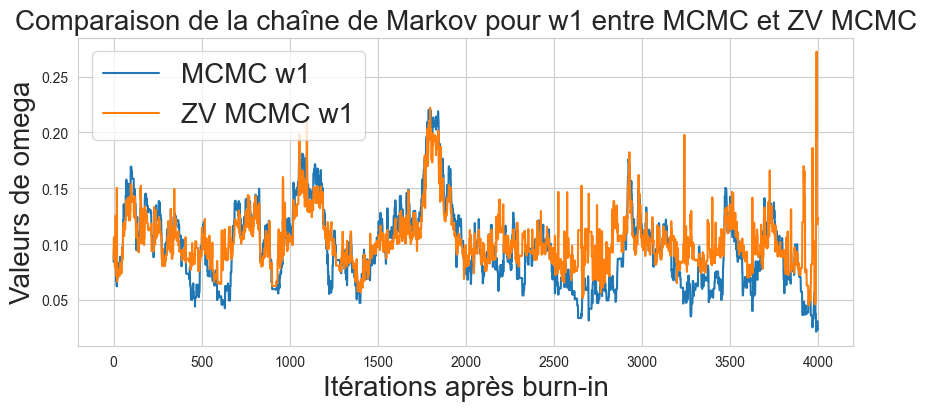

In [32]:
#w_tilde[0] correspond en réalité à w1 de la Q1
plot_comparison(w_tilde[0][:, 0], [sub_array[0] for sub_array in w1_results(w_tilde)[4]], 'w1')


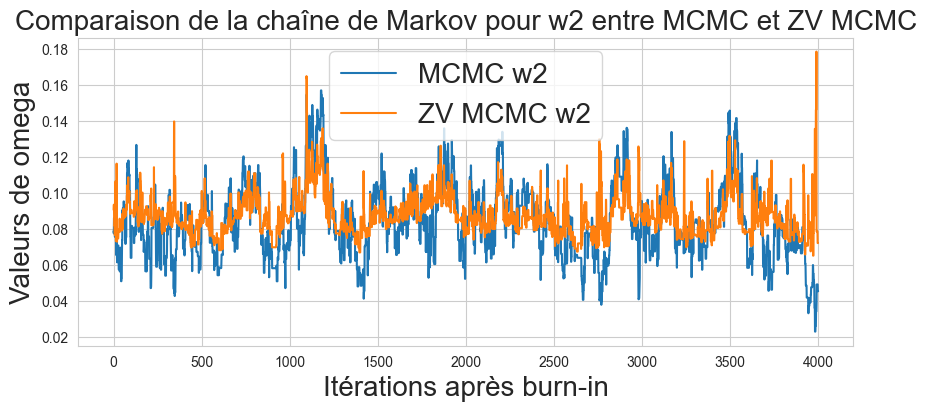

In [33]:
plot_comparison(w_tilde[0][:, 1], [sub_array[1] for sub_array in w2_results(w_tilde)[4]], 'w2')

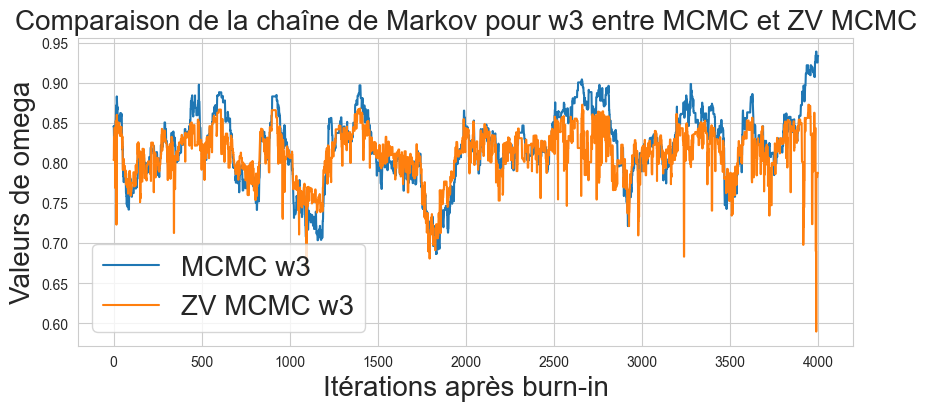

In [34]:
plot_comparison(w_tilde[0][:, 2], [sub_array[2] for sub_array in w3_results(w_tilde)[4]], 'w3')

In [35]:
def boxplot_comparison(w, w_tilde, name):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots()
    ax.boxplot([w, w_tilde])
    ax.set_xticklabels(['MCMC', 'ZC-MCMC'])
    ax.set_title('Comparision of the boxplot of the Markov Chain generated for ' + name + ' between MCMC and ZV MCMC')
    plt.show()

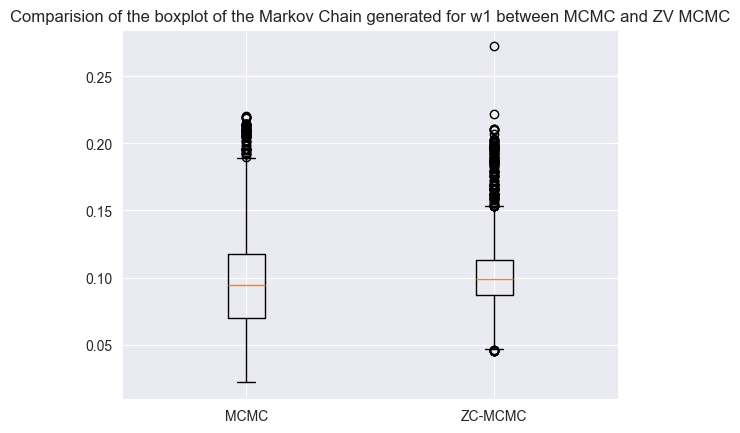

In [36]:
boxplot_comparison(w_tilde[0][:, 0], [sub_array[0] for sub_array in w1_results(w_tilde)[4]], 'w1')


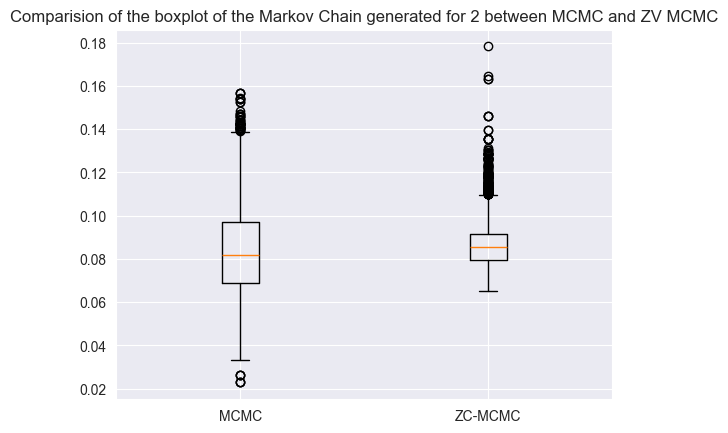

In [37]:
boxplot_comparison(w_tilde[0][:, 1], [sub_array[1] for sub_array in w2_results(w_tilde)[4]], '2')

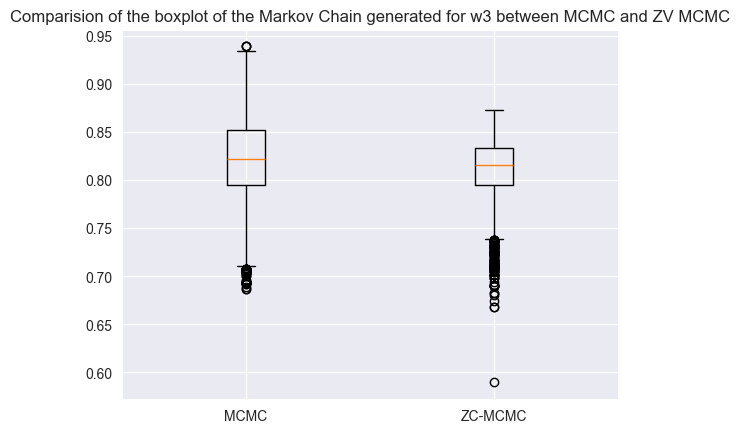

In [38]:
boxplot_comparison(w_tilde[0][:, 2], [sub_array[2] for sub_array in w3_results(w_tilde)[4]], 'w3')


We are now going to develop a function that will iterate the metropolis_hasting_algorithm in order to make statistical test and study on the distributions of the omega.


In [39]:
def mean_metropolis_algorithm(iterations_mean_algo):
    liste_w1_CV = []
    liste_w2_CV = []
    liste_w3_CV = []
    
    liste_w1_noCV = []
    liste_w2_noCV = []
    liste_w3_noCV = []
    for i in range(iterations_mean_algo):
        # Run Metropolis sampler
        samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)
    
        # Extract parameter chains
        w_samples = extract_parameter_chains(samples)
        
        # Compute control variates
        z_samples = compute_control_variates(w_samples)
        #z_samples = control_variates(returns, sigma_omega, w_samples)
        
        # Linear regression
        coefficients = fit_linear_regression(w_samples[burn_in:], z_samples[burn_in:])
        
        # Post-processing
        w, transw = post_process_samples(w_samples, z_samples, burn_in, coefficients)

        w1 = [sub_array[0] for sub_array in w]
        w2 = [sub_array[1] for sub_array in w]
        w3 = [sub_array[2] for sub_array in w]

        transw1 = [sub_array[0] for sub_array in transw]
        transw2 = [sub_array[1] for sub_array in transw]
        transw3 = [sub_array[2] for sub_array in transw]

        w1_tilde = sum_list(w1[burn_in:], transw1)
        w2_tilde = sum_list(w2[burn_in:], transw2)
        w3_tilde = sum_list(w3[burn_in:], transw3)

        liste_w1_noCV.append(np.mean(w1[burn_in:]))
        liste_w2_noCV.append(np.mean(w2[burn_in:]))
        liste_w3_noCV.append(np.mean(w3[burn_in:]))

        liste_w1_CV.append(np.mean(w1_tilde))
        liste_w2_CV.append(np.mean(w2_tilde))
        liste_w3_CV.append(np.mean(w3_tilde))
        
    return [liste_w1_CV,liste_w2_CV,liste_w3_CV], [liste_w1_noCV, liste_w2_noCV, liste_w3_noCV]

In [40]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]
true_omega = [0.1, 0.1, 0.8]  # These are the true parameters we want to estimate
sigma_omega = [9,9,9]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = true_omega, T = 1000)[0]

iterations = 5000
burn_in = 1000
sigma_proposal = 0.01

# We apply 5 times the metropolis algorithm defined in Q2
mean_metrop_algo = mean_metropolis_algorithm(5) #it took more 30 min for 50 cycles

In [41]:
def biais_estimateur(U):
    return statistics.mean(U[0]) - true_omega[0], statistics.mean(U[1]) - true_omega[1], statistics.mean(U[2]) - true_omega[2]

def mean_estimateur(U):
    return statistics.mean(U[0]), statistics.mean(U[1]), statistics.mean(U[2])

def variance_estimateur(U):
    return statistics.variance(U[0]), statistics.variance(U[1]), statistics.variance(U[2])


In [42]:
print(f"The bias of the estimator without Control Variates is: {biais_estimateur(mean_metrop_algo[1])}")
print(f"The bias of the estimator with Control Variates is: {biais_estimateur(mean_metrop_algo[0])}")

print(f"The mean of the estimator without Control Variates is: {mean_estimateur(mean_metrop_algo[1])}")
print(f"The mean of the estimator with Control Variates is: {mean_estimateur(mean_metrop_algo[0])}")

print(f"The variance of the estimator without Control Variates is: {variance_estimateur(mean_metrop_algo[1])}")
print(f"The variance of the estimator with Control Variates is: {variance_estimateur(mean_metrop_algo[0])}")


The bias of the estimator without Control Variates is: (0.013157415431029496, -0.008580408926366648, -0.002933190128586949)
The bias of the estimator with Control Variates is: (0.008004142057144198, -0.009932271501765455, 0.003428313237281544)
The mean of the estimator without Control Variates is: (0.1131574154310295, 0.09141959107363336, 0.7970668098714131)
The mean of the estimator with Control Variates is: (0.1080041420571442, 0.09006772849823455, 0.8034283132372816)
The variance of the estimator without Control Variates is: (0.00011459969974500485, 3.0812093318422335e-05, 0.0002171298444808661)
The variance of the estimator with Control Variates is: (4.475421564529896e-05, 8.871232812304191e-06, 8.252077698462924e-05)


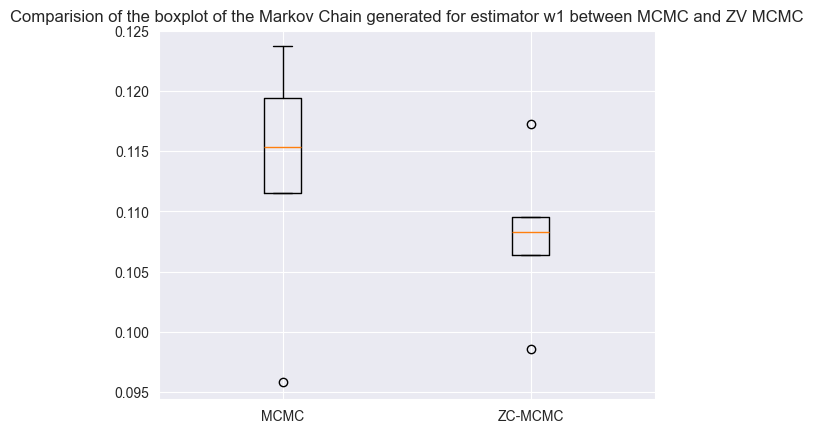

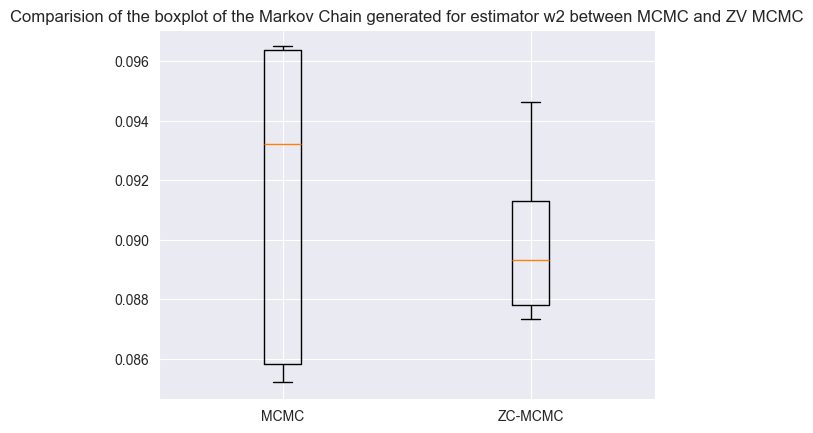

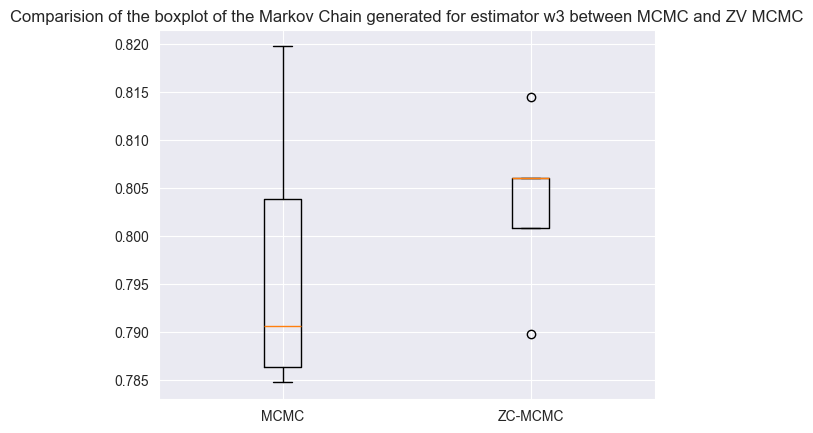

In [43]:
boxplot_comparison(mean_metrop_algo[1][0], mean_metrop_algo[0][0], 'estimator w1')
boxplot_comparison(mean_metrop_algo[1][1], mean_metrop_algo[0][1], 'estimator w2')
boxplot_comparison(mean_metrop_algo[1][2], mean_metrop_algo[0][2], 'estimator w3')

We can easily see that all the variances have been well reduced, and that the means are quite similar.

## IV - Expansion to Higher Order Polynomials

*Consider a larger set of control variates (by using a polynomial of order 2 for instance). When the number of control variates become too large, the linear regression approach of Step 2 may become too expensive (explain why). Adapt the method proposed in this paper: [https://doi.org/10.1007/s11222-021-10011-z](https://doi.org/10.1007/s11222-021-10011-z), which relies on the Lasso, to your problem, and compare with the naive approach (where you use only a single step based on a linear regression).*


### Handling Computational Complexity in Control Variates with Linear Regression

#### Computational Challenges with Increasing Control Variates

The number of control variates increases significantly with the degree of the polynomial used in modeling. For example, in a 3-dimensional space, a polynomial of degree $p$ results in $\binom{d+p}{d}-1$ control variates. Specifically:

- First-order polynomial: 3 control variates ($z_1, z_2, z_3$).
- Second-order polynomial: 9 control variates ($z_1, z_2, z_3, z_1*z_2, z_3*z_3, z_1*z_3, z_1^2, z_2^2, z_3^2$).
- Third-order polynomial: 19 control variates.

The increase in control variates leads to a surge in computational complexity, primarily because the Ordinary Least Squares (OLS) regression's time complexity is influenced by the number of control variates ($m$) and samples ($n$), detailed as $O(nm^2 + m^3)$.

#### Simplifying the OLS Model with LASSO

To manage the rising computational cost with higher polynomial degrees, the use of LASSO (Least Absolute Shrinkage and Selection Operator) regression is recommended. LASSO assists in both variable selection and regularization, reducing the number of control variates effectively by imposing a penalty proportional to the absolute value of the coefficients:

$$\displaystyle \min_{\beta \in \mathbb{R}^p} \left(\frac{1}{N} |y - X\beta|_2^2 + \lambda |\beta|_1\right)$$

where $\lambda$ is a regularization parameter determining the penalty's strength.

#### Implementing LASSO for Second-Order Polynomial Control Variates

##### Step-by-Step Approach:

1. **Gradient Computation**: Compute the control variates for a second-order polynomial, which includes both linear terms and interaction terms ($z_1, z_2, z_3, z_1*z_2, z_1*z_3, z_2*z_3, z_1^2, z_2^2, z_3^2$).

2. **Optimizing $\lambda$ with LASSO Cross Validation**: Employ LASSO CV to determine the optimal $\lambda$ while regressing the function $f(w_i)$ on the vector of control variates $[z_i]$ as in Question 2 (but we have 9 control variates instead of 3 so 9 parameters to estimate for each $w_i$).

3. **Subsampling with LASSO Regression**: Conduct LASSO regression to determine which control variates have a significant effect on the response variable, effectively reducing the number of variables used in the final model.

4. **Finalizing with OLS Regression**: With the reduced set of control variates post-LASSO, perform OLS regression to estimate the optimal coefficients.

5. **Evaluation**: Compare the empirical mean and variance of the adjusted function $\tilde{f}(w_i)$ with $f(w_i)$ to verify if the variance has been reduced while maintaining the expected value.

##### Polynomial Representation in LASSO:

For quadratic polynomials represented as $P(x) = a^T x + \frac{1}{2} x^T B x$, the re-normalized function becomes:

$$\tilde{f}(x) = f(x) - \frac{1}{2} \operatorname{tr}(B) + (a + Bx)^T z$$

Here, if we note $\alpha_1$, $\alpha_2$, $\alpha_3$, $\alpha_{12}$, $\alpha_{13}$, $\alpha_{23}$, $\alpha_{11}$, $\alpha_{22}$ and $\alpha_{33}$ the coefficients of $z_1$, $z_2$, $z_3$,$z_1\times z_2$, $z_1\times z_3$, $z_2\times z_3$, $z_1^2$, $z_2^2$ and $z_3^2$, then we have : $a = [\alpha_1, \alpha_2, \alpha_3]$ and 
$ B = \begin{pmatrix}
\alpha_{11} & \alpha_{12} & \alpha_{13} \\
\alpha_{21} & \alpha_{22} & \alpha_{23} \\
\alpha_{31} & \alpha_{32} & \alpha_{33} \\
\end{pmatrix}$ 

But with B symmetric so we only have 6 distinct coefficients in this matrix. This approach not only optimizes the computational effort but also enhances the model's interpretability and efficiency by focusing on the most influential terms.


### Implementation

***Step 0 :*** Let's remember the functions we'll have to use

In [44]:
def simulate_garch(T, omega_1, omega_2, omega_3):
    np.random.seed(423)  # For reproducibility
    r = np.zeros(T)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3)
    r[0] = np.random.normal(0, np.sqrt(abs(h[0]))) # abs

    
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        r[t] = np.random.normal(0, np.sqrt(abs(h[t]))) #abs
        
    return r, h

def log_likelihood(r, omega_1, omega_2, omega_3):
    T = len(r)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3) if (omega_2 + omega_3) < 1 else 100000  # large number for stability
    
    log_lik = 0
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        log_lik -= 0.5 * (np.log(abs(h[t])) + r[t]**2 / h[t]) # abs
    
    return log_lik

def log_posterior(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    log_prior = -0.5 * (omega_1**2 / sigma_1**2 + omega_2**2 / sigma_2**2 + omega_3**2 / sigma_3**2)
    return log_likelihood(r, omega_1, omega_2, omega_3) + log_prior

def proposal(omega_old, sigma_proposal ): # function used in the MH algorithm that will "propose" the new parameter (new omega here)
    # omega_old is the list containing the old omegas, we will use a normal probability distribution to determine the new ones
    omega = np.array([0.0,0.0,0.0])
    omega[0] = np.random.normal(loc= omega_old[0], scale = sigma_proposal)
    omega[1] = np.random.normal(loc= omega_old[1], scale = sigma_proposal)
    omega[2] = np.random.normal(loc= omega_old[2], scale = sigma_proposal)

    return omega

def metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega):
    # Let's initialize our variable
    acceptation = np.array([False]*iterations) # we will through the iterations accept or not the change of value of omega
    omega = initial_omega
    omega_sampling = [omega]
    # Let's apply the algorithm trough all the iterations
    for t in range(iterations):
        # We propose a candidate for omegas
        omega_new = proposal(omega, sigma_proposal)
        # We calculate the acceptance alpha which is ratio of the prior of the new omega over the old omega
        alpha = log_posterior(returns,omega_new[0],omega_new[1],omega_new[2],sigma_omega[0],sigma_omega[1],sigma_omega[2]) - log_posterior(returns,omega[0],omega[1],omega[2],sigma_omega[0],sigma_omega[1],sigma_omega[2])
        # We compare alpha with 1 and an uniform random number
        u = np.random.uniform(0,1)
        if alpha > 0:  # reminder that alpha is a log here so we don't compare with 1 but with 0
            acceptation[t] = True
            omega = omega_new
        if alpha < 0:
            if alpha > np.log(u): # we compare to log u and not u
                acceptation[t]= False
                omega = omega_new # we take the new omega
        omega_sampling.append(omega)
    acceptance_rate = np.sum(acceptation)/len(acceptation)*100
    return acceptance_rate, omega_sampling



In [45]:
def compute_h_t_derivatives(r, omega_1, omega_2, omega_3):
    T = len(r)
    h = np.zeros(T)
    grad_h_omega1 = np.zeros(T)
    grad_h_omega2 = np.zeros(T)
    grad_h_omega3 = np.zeros(T)

    # Initial volatility
    h[0] = omega_1  

    # Compute h and its derivatives
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        
        # Derivative of h_t with respect to omega_1
        grad_h_omega1[t] = (1 - omega_3**(t)) / (1 - omega_3) if omega_3 != 1 else t  # Using the geometric series

        # Derivative of h_t with respect to omega_2
        grad_h_omega2[t] = r[t-1]**2 + omega_3 * grad_h_omega2[t-1]

        # Derivative of h_t with respect to omega_3
        grad_h_omega3[t] = h[t-1] + omega_3 * grad_h_omega3[t-1]

    return h, grad_h_omega1, grad_h_omega2, grad_h_omega3

def compute_log_posterior_gradients(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    h, grad_h_omega1, grad_h_omega2, grad_h_omega3 = compute_h_t_derivatives(r, omega_1, omega_2, omega_3)
    T = len(r)
    gradients = np.zeros(3)

    # Compute the gradient of the log-posterior for each parameter
    gradients[0] = -omega_1 / sigma_1**2 - 0.5 * np.sum((1 / h) * grad_h_omega1 - (r**2 / h**2) * grad_h_omega1)
    gradients[1] = -omega_2 / sigma_2**2 - 0.5 * np.sum((1 / h) * grad_h_omega2 - (r**2 / h**2) * grad_h_omega2)
    gradients[2] = -omega_3 / sigma_3**2 - 0.5 * np.sum((1 / h) * grad_h_omega3 - (r**2 / h**2) * grad_h_omega3)

    return gradients

In [46]:
def compute_log_posterior_gradients_concatenator(r, sigma_1, sigma_2, sigma_3,w1_samples,w2_samples,w3_samples):
    '''
    This function computes the log posterior gradients at every points
    '''
    gradient_concat=[]
    i = 0
    for _ in r:
        gradient_concat.append(compute_log_posterior_gradients(r, w1_samples[i],w2_samples[i],w3_samples[i], sigma_1, sigma_2, sigma_3))
        i = i +1 
    return np.array(gradient_concat)

And let's define a new function that will help us calculte the 6 missing control variates

In [47]:
def list_mult(x,y):
    result = []
    # The 2 lists must be of same length
    for i in range(len(x)):
        product = x[i] * y[i]
        result.append(product)
    return result

Let's also import the new functions we'll have to use later

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import MultiTaskLassoCV

***Step 1 :*** Compute the 6 new control variates

In [49]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.4]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Metropolis-Hastings settings
iterations = 5000
burn_in = 1000
sigma_proposal = 0.01

# Parameters (example values)
omega_1, omega_2, omega_3 =0.1, 0.1, 0.8
sigma_1, sigma_2, sigma_3 = 9, 9, 9
# Simulate data
T = iterations + 1 # Number of time points
r, h = simulate_garch(T, true_omega[0], true_omega[1], true_omega[2])

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, r, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We compute the log posterior gradients at every point
log_post_gradient = compute_log_posterior_gradients_concatenator(r, sigma_1, sigma_2, sigma_3, w1_samples, w2_samples, w3_samples)

# We compute the control variates (z_i)
z1 = [ex[0] if isinstance(ex, np.ndarray) else ex[0] for ex in log_post_gradient]
z2 = [ex[1] if isinstance(ex, np.ndarray) else ex[1] for ex in log_post_gradient]
z3 = [ex[2] if isinstance(ex, np.ndarray) else ex[2] for ex in log_post_gradient]

z1z2 = list_mult(z1, z2)
z1z3 = list_mult(z1, z3)
z2z3 = list_mult(z2, z3)
z1_square = list_mult(z1, z1)
z2_square = list_mult(z2, z2)
z3_square = list_mult(z3, z3)

# We store these 9 control variates in an array 
z = np.column_stack((z1, z2, z3, z1z2, z1z3, z2z3, z1_square, z2_square, z3_square))


In [50]:
z

array([[3.84557902e+03, 1.10675770e+04, 9.86898076e+03, ...,
        1.47884780e+07, 1.22491262e+08, 9.73967812e+07],
       [3.84557902e+03, 1.10675770e+04, 9.86898076e+03, ...,
        1.47884780e+07, 1.22491262e+08, 9.73967812e+07],
       [3.84557902e+03, 1.10675770e+04, 9.86898076e+03, ...,
        1.47884780e+07, 1.22491262e+08, 9.73967812e+07],
       ...,
       [7.10645000e+00, 3.96999555e+02, 3.83220842e+02, ...,
        5.05016316e+01, 1.57608647e+05, 1.46858214e+05],
       [7.10645000e+00, 3.96999555e+02, 3.83220842e+02, ...,
        5.05016316e+01, 1.57608647e+05, 1.46858214e+05],
       [7.10645000e+00, 3.96999555e+02, 3.83220842e+02, ...,
        5.05016316e+01, 1.57608647e+05, 1.46858214e+05]])

We indeed obtained our new z, with 9 control variates for each iteration

***Step 2 :*** Lasso cross validation to find the best hyperparameter

In [51]:
# We store our data in arrays after burn in 
w = np.column_stack((w1_samples, w2_samples, w3_samples))
Y = np.array(w[burn_in:])
Z = np.array(z[burn_in:])

# We also store especially w1,w2 and w3, it might be useful later
Y1 = np.array(w1_samples[burn_in:])
Y2 = np.array(w2_samples[burn_in:])
Y3 = np.array(w3_samples[burn_in:])

In [52]:
# We do a Lasso Cross Validation in order to find the optimal parameter lambda : step 2 of the method

lambdas_test = [0.0001, 0.0001, 0.001, 0.1, 1, 1.5] # List of hyperparameters that will be tested through Cross Validation

lasso_cv = LassoCV(cv=5) # évaluer les performances de la régression Lasso

lasso_cv.fit(Z,Y1) # utilisation de la validation croisée, avec Z variable de controle, Y variable expliquée

print("Optimal lambda:", lasso_cv.alpha_)

Optimal lambda: 0.9569567913835515


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007859554789024781, tolerance: 0.0006274315532178564
  model = cd_fast.enet_coordinate_descent_gram(
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007701482585110719, tolerance: 0.0006274315532178564
  model = cd_fast.enet_coordinate_descent_gram(
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000736520083183867, tolerance: 0.0006274315532178564
  model = cd_fast.enet_coordinate_descent_gram(
/Users/antoine/Library/

We obtain our optimal lambda : 0.95

***Step 3 :*** Lasso regression using the parameters we found, and only using the most useful control variates.

In [53]:
# With the optimal lambda we just found, we do a Lasso regression to select the variables
lasso_best = Lasso(alpha=lasso_cv.alpha_)
lasso_best.fit(Y,Z)
coeff_lasso = lasso_best.coef_

In [54]:
coeff_lasso

array([[-0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-1.06054795e+02, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00, -2.20277244e+02],
       [-2.69367537e+05, -2.17808379e+05, -7.54943676e+05],
       [-2.68760151e+05, -2.22200826e+05, -7.43722664e+05],
       [-1.30340732e+06, -5.09993300e+06, -9.50815696e+06],
       [-3.48547501e+03, -0.00000000e+00,  0.00000000e+00],
       [-7.53443919e+05, -4.38465249e+06, -5.76984731e+06],
       [-1.82621175e+06, -5.77029904e+06, -1.31701080e+07]])

We can see that indeed, some coefficients have been set to 0 by Lasso !

In [55]:
def real_extract_non_null(coeff_lasso): # the goal is to extract the rows of the Z matrix where the coefficients of each w_i are not zero

    # Indexes of the non nul coefficients in the first, second and third column
    nonnull_w1 = np.nonzero(coeff_lasso[:, 0])[0].tolist()
    nonnull_w2 = np.nonzero(coeff_lasso[:, 1])[0].tolist()
    nonnull_w3 = np.nonzero(coeff_lasso[:, 2])[0].tolist()
    # We initialize empty lists for the 3 regressions that we are going to do of each w_i on the Z kept.
    controlvarw1 = []
    controlvarw2 = []
    controlvarw3 = []

    for i in range(len(Z)):
        # We fulfill the 3 lists with the non null values remaining of the z_i
        controlvarw1.append([Z[i,j] for j in nonnull_w1])
        controlvarw2.append([Z[i,j] for j in nonnull_w2])
        controlvarw3.append([Z[i,j] for j in nonnull_w3])
        
    return np.asarray(controlvarw1), np.asarray(controlvarw2), np.asarray(controlvarw3)

# returns lists where the coefficients representing w_i is not null


***Step 4 :*** OLS regression using the parameters we kept, and finding their optimal values

Now, let's do the 3 regressions of w_1, w_2 and w_3 on Z with the control variates we kept.

In [56]:
def OLS_reg(coeff_lasso, w1, w2, w3):
    controlvarw1, controlvarw2, controlvarw3 = real_extract_non_null(coeff_lasso)
    reg1 = LinearRegression()
    reg1.fit(controlvarw1, w1) # On fait la regression seulement sur la partie qui n'est pas nulle
    coeff_reg1 = reg1.coef_.tolist()
    reg2 = LinearRegression()
    reg2.fit(controlvarw2, w2)
    coeff_reg2 = reg2.coef_.tolist()
    reg3 = LinearRegression()
    reg3.fit(controlvarw3, w3)
    coeff_reg3 = reg3.coef_.tolist()

    # We return the coefficient of the 3 regressions
    return coeff_reg1, coeff_reg2, coeff_reg3


Now, lets create the matrix as depicted in the paper, the 3x3 matrix, dimension 9.

In [57]:

def matrix_coeff(coeff_lasso, w1, w2, w3):
    coeff_reg1 = OLS_reg(coeff_lasso, w1, w2, w3)[0]
    coeff_reg2 = OLS_reg(coeff_lasso, w1, w2, w3)[1]
    coeff_reg3 = OLS_reg(coeff_lasso, w1, w2, w3)[2]

    # We add 0 to the z_i that were removed after Lasso to have again our 9 control variates 
    # vectors with some values therefore equal to 0 if the control variate was not used
    # Thus we still are in dimension 9 while having removed the useless coefficients

    for i in np.where(coeff_lasso[:, 0] == 0)[0]:
        coeff_reg1.insert(i,0)
    for j in np.where(coeff_lasso[:, 1] == 0)[0]:
        coeff_reg2.insert(j,0)
    for l in np.where(coeff_lasso[:, 2] == 0)[0]:
        coeff_reg3.insert(l,0)
        
    #This corresponds, for each wi, to the 3 first coefficients of the control variates associated to each linear regression
    A_reg1 = [coeff_reg1[i] for i in range(3)]
    A_reg2 = [coeff_reg2[i] for i in range(3)]
    A_reg3 = [coeff_reg3[i] for i in range(3)]
    # direct effects of control variables on the parameter, constant
    
    # B is symmetric so we only need 6 coefficients for the 6 remaining coefficients of the control variates, for each of the 3 regression
    # First regression 
    reg1_B11 = coeff_reg1[6]
    reg1_B12 = coeff_reg1[3]
    reg1_B13 = coeff_reg1[5]
    reg1_B22 = coeff_reg1[7]
    reg1_B23 = coeff_reg1[4]
    reg1_B33 = coeff_reg1[8]
    B_reg1 = np.array([[reg1_B11,reg1_B12,reg1_B13],[reg1_B12,reg1_B22,reg1_B23],[reg1_B13,reg1_B23,reg1_B33]])
    # Coviarance matrix
    
    # Second regression 
    reg2_B11 = coeff_reg2[6]
    reg2_B12 = coeff_reg2[3]
    reg2_B13 = coeff_reg2[5]
    reg2_B22 = coeff_reg2[7]
    reg2_B23 = coeff_reg2[4]
    reg2_B33 = coeff_reg2[8]
    B_reg2 = np.array([[reg2_B11,reg2_B12,reg2_B13],[reg2_B12,reg2_B22,reg2_B23],[reg2_B13,reg2_B23,reg2_B33]])
    
    # Third regression 
    reg3_B11 = coeff_reg3[6]
    reg3_B12 = coeff_reg3[3]
    reg3_B13 = coeff_reg3[5]
    reg3_B22 = coeff_reg3[7]
    reg3_B23 = coeff_reg3[4]
    reg3_B33 = coeff_reg3[8]
    B_reg3 = np.array([[reg3_B11,reg3_B12,reg3_B13],[reg3_B12,reg3_B22,reg3_B23],[reg3_B13,reg3_B23,reg3_B33]])
    
    return A_reg1, B_reg1, A_reg2, B_reg2, A_reg3, B_reg3

Now, we've obtained the optimal coefficients for the matrix B (symmetric so thats why we have only 6)

***Step 5 :*** Computing the values and their variance

We'll need to create a Trace function as we know the form of the polynom when it's a second order case. 
Indeed, for quadratic polynomials $P(x) = a^T\times x + \frac{1}{2}\times x^TBx$ (as given in the paper), the re-normalized $\tilde{f}$ is now:$\tilde{f}(x) = f(x) - \frac{1}{2}\operatorname{tr}(B) + (a + Bx)^Tz$. 

In [58]:
def trace(B):
    return(B[0,0] + B[1,1] + B[2,2])

Let's compute the estimators of all w now that we added control variates

In [59]:
def ZV_MCMC_estimator(coeff_lasso, w1, w2, w3):
    a_reg1, B_reg1, a_reg2, B_reg2, a_reg3, B_reg3 = matrix_coeff(coeff_lasso, w1, w2, w3)
    trace_reg1, trace_reg2, trace_reg3 = trace(B_reg1), trace(B_reg2), trace(B_reg3)
    w1_tilde = [w1[i] - (0.5)*trace_reg1 + np.dot(a_reg1 + np.dot(B_reg1,Y[i]), w1[i]) for i in range(len(Y1))]
    w2_tilde = [w2[i] - (0.5)*trace_reg2 + np.dot(a_reg2 + np.dot(B_reg2,Y[i]), w2[i]) for i in range(len(Y2))]
    w3_tilde = [w3[i] - (0.5)*trace_reg3 + np.dot(a_reg3 + np.dot(B_reg3,Y[i]), w3[i]) for i in range(len(Y3))]
    return w1_tilde, w2_tilde, w3_tilde

w1_tilde, w2_tilde, w3_tilde = ZV_MCMC_estimator(coeff_lasso, Y1, Y2, Y3)

Let's now compare our new estimation of w with the previous ones, without the addition of control variates.

In [60]:

print("Mean of w_1 for the ZV MCMC method with control variates =", np.mean(w1_tilde))
print("Mean of w_1 for the MCMC method without control variates =", np.mean(w1_samples[:burn_in]))
print("Variance of w_1 for the ZV MCMC method with control variates =", np.var(w1_tilde))
print("Variance of w_1 for the MCMC method without control variates =", np.var(w1_samples[:burn_in]))


Mean of w_1 for the ZV MCMC method with control variates = 0.6825050158775506
Mean of w_1 for the MCMC method without control variates = 0.5579056386090606
Variance of w_1 for the ZV MCMC method with control variates = 0.002138995921431592
Variance of w_1 for the MCMC method without control variates = 0.009411801142404717


In [61]:

print("Mean of w_2 for the ZV MCMC method with control variates =", np.mean(w2_tilde))
print("Mean of w_2 for the MCMC method without control variates =", np.mean(w2_samples[:burn_in]))
print("Variance of w_2 for the ZV MCMC method with control variates =", np.var(w2_tilde))
print("Variance of w_2 for the MCMC method with control variates =", np.var(w2_samples[:burn_in]))


Mean of w_2 for the ZV MCMC method with control variates = 0.5894688416283487
Mean of w_2 for the MCMC method without control variates = 0.5490795035885889
Variance of w_2 for the ZV MCMC method with control variates = 0.00022205370348648564
Variance of w_2 for the MCMC method with control variates = 0.0035062905870453685


In [62]:

print("Mean of w_3 for the ZV MCMC method with control variates =", np.mean(w3_tilde))
print("Mean of w_3 for the MCMC method with control variates =", np.mean(w3_samples[:burn_in]))
print("Variance of w_3 for the ZV MCMC method with control variates =", np.var(w3_tilde))
print("Variance of w_3 for the MCMC method with control variates =", np.var(w3_samples[:burn_in]))

Mean of w_3 for the ZV MCMC method with control variates = 0.40552324655536287
Mean of w_3 for the MCMC method with control variates = 0.43167609823790826
Variance of w_3 for the ZV MCMC method with control variates = 0.00021218629568317296
Variance of w_3 for the MCMC method with control variates = 0.0012175503392140314


In [81]:
print("The ratio of variance reduction for w_1 is =", np.mean(w1_samples[:burn_in])/np.mean(w1_tilde))
print("The ratio of variance reduction for w_2 is =", np.mean(w2_samples[:burn_in])/np.mean(w2_tilde))
print("The ratio of variance reduction for w_3 is =", np.mean(w3_samples[:burn_in])/np.mean(w3_tilde))

The ratio of variance reduction for w_1 is = 0.8174381515595417
The ratio of variance reduction for w_2 is = 0.9314818100848414
The ratio of variance reduction for w_3 is = 1.0644916213921043


For every w, the variance reduction method works, (maybe not so much for w_3) and is closer to the real value of w. The ZV-MCMC method worked in an higher dimensional space !

To have a better idea of how well or not does this method work, we could compare this LASSO method with the naive method which only consists in doing the full regression of f on -z in order to find the optimal coefficients 9 components in the vector for the 2nd order polynomial case (instead of 3 in Question 2 with 1st order polynomial case).

It should lead to a lower variance but a longer time for the execution of the algorithm, which is why we would prefer use the LASSO Method when we have a high degre polynomial case.

In [63]:
# First, we have to compute everything again


initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.4]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Metropolis-Hastings settings
iterations = 5000
burn_in = 1000
sigma_proposal = 0.01

# Parameters (example values)
omega_1, omega_2, omega_3 =0.1, 0.1, 0.8
sigma_1, sigma_2, sigma_3 = 9, 9, 9
# Simulate data
T = iterations + 1 # Number of time points
r, h = simulate_garch(T, true_omega[0], true_omega[1], true_omega[2])

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, r, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We compute the log posterior gradients at every point
log_post_gradient = compute_log_posterior_gradients_concatenator(r, sigma_1, sigma_2, sigma_3, w1_samples, w2_samples, w3_samples)

# We compute the control variates (z_i)
z1 = [ex[0] if isinstance(ex, np.ndarray) else ex[0] for ex in log_post_gradient]
z2 = [ex[1] if isinstance(ex, np.ndarray) else ex[1] for ex in log_post_gradient]
z3 = [ex[2] if isinstance(ex, np.ndarray) else ex[2] for ex in log_post_gradient]

z1z2 = list_mult(z1, z2)
z1z3 = list_mult(z1, z3)
z2z3 = list_mult(z2, z3)
z1_square = list_mult(z1, z1)
z2_square = list_mult(z2, z2)
z3_square = list_mult(z3, z3)

# We store these 9 control variates in an array 
z = np.column_stack((z1, z2, z3, z1z2, z1z3, z2z3, z1_square, z2_square, z3_square))

Y = np.array(w[burn_in:])
Z = np.array(z[burn_in:])
Y1 = np.array(w1_samples[burn_in:])
Y2 = np.array(w2_samples[burn_in:])
Y3 = np.array(w3_samples[burn_in:])
# We do the 3 regressions of w_1, w_2 and w_3 on Z : step 4 of the method 


### The difference with the Lasso Method is here in OLS_bis : we regress on the full vector of control variate Z, instead of using the lasso method to determine the most important components.

In [64]:

def OLS_naive(w1, w2, w3): # New OLS function, that regresses the w_i on all Z, and not a new Z made by Lasso
    reg1 = LinearRegression()
    reg1.fit(Z, w1) # On fait la regression sur l'entiéreté de Z
    coeff_reg1 = reg1.coef_.tolist()
    reg2 = LinearRegression()
    reg2.fit(Z, w2)
    coeff_reg2 = reg2.coef_.tolist()
    reg3 = LinearRegression()
    reg3.fit(Z, w3)
    coeff_reg3 = reg3.coef_.tolist()
    # We return the coefficient of the 3 regressions
    return coeff_reg1, coeff_reg2, coeff_reg3
# We compute the a vector as well as the B matrix defined in the article and previously in the notebook

def matrix_coeff_naive(w1, w2, w3):
    coeff_reg1 = OLS_naive(w1, w2, w3)[0]
    coeff_reg2 = OLS_naive(w1, w2, w3)[1]
    coeff_reg3 = OLS_naive(w1, w2, w3)[2]
        
    #This corresponds, for each wi, to the 3 first coefficients of the control variates associated to each linear regression
    a_reg1 = [coeff_reg1[i] for i in range(3)]
    a_reg2 = [coeff_reg2[i] for i in range(3)]
    a_reg3 = [coeff_reg3[i] for i in range(3)]
    
    # B is symmetric so we only need 6 coefficients for the 6 remaining coefficients of the control variates, for each of the 3 regression
    # First regression 
    reg1_b11 = coeff_reg1[6]
    reg1_b12 = coeff_reg1[3]
    reg1_b13 = coeff_reg1[5]
    reg1_b22 = coeff_reg1[7]
    reg1_b23 = coeff_reg1[4]
    reg1_b33 = coeff_reg1[8]
    B_reg1 = np.array([[reg1_b11,reg1_b12,reg1_b13],[reg1_b12,reg1_b22,reg1_b23],[reg1_b13,reg1_b23,reg1_b33]])
    
    # Second regression 
    reg2_b11 = coeff_reg2[6]
    reg2_b12 = coeff_reg2[3]
    reg2_b13 = coeff_reg2[5]
    reg2_b22 = coeff_reg2[7]
    reg2_b23 = coeff_reg2[4]
    reg2_b33 = coeff_reg2[8]
    B_reg2 = np.array([[reg2_b11,reg2_b12,reg2_b13],[reg2_b12,reg2_b22,reg2_b23],[reg2_b13,reg2_b23,reg2_b33]])
    
    # Third regression 
    reg3_b11 = coeff_reg3[6]
    reg3_b12 = coeff_reg3[3]
    reg3_b13 = coeff_reg3[5]
    reg3_b22 = coeff_reg3[7]
    reg3_b23 = coeff_reg3[4]
    reg3_b33 = coeff_reg3[8]
    B_reg3 = np.array([[reg3_b11,reg3_b12,reg3_b13],[reg3_b12,reg3_b22,reg3_b23],[reg3_b13,reg3_b23,reg3_b33]])
    
    return a_reg1, B_reg1, a_reg2, B_reg2, a_reg3, B_reg3

def trace(B):
    return(B[0,0] + B[1,1] + B[2,2])

def ZV_MCMC_naive(w1, w2, w3):
    a_reg1, B_reg1, a_reg2, B_reg2, a_reg3, B_reg3 = matrix_coeff_naive(w1, w2, w3)
    trace_reg1, trace_reg2, trace_reg3 = trace(B_reg1), trace(B_reg2), trace(B_reg3)
    w1_tilde = [w1[i] - (0.5)*trace_reg1 + np.dot(a_reg1 + np.dot(B_reg1,Y[i]), w1[i]) for i in range(len(Y1))]
    w2_tilde = [w2[i] - (0.5)*trace_reg2 + np.dot(a_reg2 + np.dot(B_reg2,Y[i]), w2[i]) for i in range(len(Y2))]
    w3_tilde = [w3[i] - (0.5)*trace_reg3 + np.dot(a_reg3 + np.dot(B_reg3,Y[i]), w3[i]) for i in range(len(Y3))]
    return w1_tilde, w2_tilde, w3_tilde

In [65]:
w1_tilde_bis, w2_tilde_bis, w3_tilde_bis = ZV_MCMC_naive(Y1, Y2, Y3)

In [66]:

print("Mean of w_1 for the ZV MCMC method with control variates =", np.mean(w1_tilde))
print("Mean of w_1_bis for the ZV MCMC method with control variates =", np.mean(w1_tilde_bis))
print("Mean of w_1 for the MCMC method without control variates =", np.mean(w1_samples[:burn_in]))
print("Variance of w_1 for the ZV MCMC method with control variates =", np.var(w1_tilde))
print("Variance of w_1 for the ZV MCMC method with control variates =", np.var(w1_tilde_bis))
print("Variance of w_1 for the MCMC method without control variates =", np.var(w1_samples[:burn_in]))


Mean of w_1 for the ZV MCMC method with control variates = 0.6825050158775506
Mean of w_1_bis for the ZV MCMC method with control variates = 0.6822246998655216
Mean of w_1 for the MCMC method without control variates = 0.5579056386090606
Variance of w_1 for the ZV MCMC method with control variates = 0.002138995921431592
Variance of w_1 for the ZV MCMC method with control variates = 0.0021377844225412106
Variance of w_1 for the MCMC method without control variates = 0.009411801142404717


In [67]:

print("Mean of w_2 for the ZV MCMC method with control variates =", np.mean(w2_tilde))
print("Mean of w_2_bis for the ZV MCMC method with control variates =", np.mean(w2_tilde_bis))
print("Mean of w_2 for the MCMC method without control variates =", np.mean(w2_samples[:burn_in]))
print("Variance of w_2 for the ZV MCMC method with control variates =", np.var(w2_tilde))
print("Variance of w_2_bis for the ZV MCMC method with control variates =", np.var(w2_tilde_bis))
print("Variance of w_2 for the MCMC method with control variates =", np.var(w2_samples[:burn_in]))


Mean of w_2 for the ZV MCMC method with control variates = 0.5894688416283487
Mean of w_2_bis for the ZV MCMC method with control variates = 0.5893708763068634
Mean of w_2 for the MCMC method without control variates = 0.5490795035885889
Variance of w_2 for the ZV MCMC method with control variates = 0.00022205370348648564
Variance of w_2_bis for the ZV MCMC method with control variates = 0.00022202704487587707
Variance of w_2 for the MCMC method with control variates = 0.0035062905870453685


In [68]:

print("Mean of w_3 for the ZV MCMC method with control variates =", np.mean(w3_tilde))
print("Mean of w_3_bis for the ZV MCMC method with control variates =", np.mean(w3_tilde_bis))
print("Mean of w_3 for the MCMC method with control variates =", np.mean(w3_samples[:burn_in]))
print("Variance of w_3 for the ZV MCMC method with control variates =", np.var(w3_tilde))
print("Variance of w_3_bis for the ZV MCMC method with control variates =", np.var(w3_tilde_bis))
print("Variance of w_3 for the MCMC method with control variates =", np.var(w3_samples[:burn_in]))

Mean of w_3 for the ZV MCMC method with control variates = 0.40552324655536287
Mean of w_3_bis for the ZV MCMC method with control variates = 0.4055751155767003
Mean of w_3 for the MCMC method with control variates = 0.43167609823790826
Variance of w_3 for the ZV MCMC method with control variates = 0.00021218629568317296
Variance of w_3_bis for the ZV MCMC method with control variates = 0.00021224994690601496
Variance of w_3 for the MCMC method with control variates = 0.0012175503392140314


Conclusion : the naive method indeed lowered the vairance, but just by a little margin, but it took longer to compute. That is not worth doing it, we would prefer LASSO !

## V - Bonus: Linear Regression Validity

*Is the fact that we do linear regression completely valid when applied to an MCMC sample? Try to think of ways to address this issue. Hint: you could think of ways to make MCMC simulations less "dependent", by sub-sampling, or averaging over blocks of a given size, or another approach.*

### Challenges of Applying Linear Regression to MCMC Samples

Linear regression is a widely used statistical tool that relies on specific assumptions to be effective:

- **Measurement Accuracy**: Observations must be accurately measured without error.
- **Sufficient Observations**: There should be more observations than explanatory variables.
- **No Collinearity**: The explanatory variables should not be collinear.
- **Independence**: Observations need to be independent and identically distributed (iid).
- **Homoscedasticity**: The variance of the residuals should be constant across all values of the independent variable.
- **Normality**: Residuals must be normally distributed.

#### Independence Issue with MCMC Samples

In the Metropolis-Hastings MCMC framework, the sequence of samples forms a Markov chain where each step depends on the previous one. This dependency violates the independence assumption necessary for linear regression, potentially leading to biased estimates and underestimation of standard errors. 

##### Subsampling as a Solution

**Objective**: Reduce dependency between observations to enable the effective use of linear regression.

**Methodology**:
- Randomly select a subset of data from the original dataset.
- Create a smaller, representative design submatrix that maintains essential statistical properties.

**Effectiveness**: Subsampling addresses the dependency problem by breaking the sequence of observations and allowing a random, non-sequential selection of data. This process reduces interdependencies and makes the application of linear regression more appropriate. (This method is well-documented in literature, notably in "Optimal Subsampling Approaches for Large Sample Linear Regression" by Rong Zhu, Ping Ma, Michael W. Mahoney, and Bin Yu.)

While linear regression may not be directly applicable to MCMC samples due to their dependency structure, subsampling offers a practical workaround. By effectively reducing dependencies within the data, subsampling allows for more reliable and unbiased application of linear regression, ensuring that the assumptions of independence and homoscedasticity are better met.

### Implementation

In [69]:
def simulate_garch(T, omega):
    np.random.seed(111)  # For reproducibility
    r = np.zeros(T)
    h = np.zeros(T)
    h[0] = omega[0] / (1 - omega[1] - omega[2])
    r[0] = np.random.normal(0, np.sqrt(abs(h[0]))) # abs

    
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        r[t] = np.random.normal(0, np.sqrt(abs(h[t]))) #abs
        
    return r, h

In [70]:
def log_likelihood(r, omega):
    T = len(r)
    h = np.zeros(T)
    h[0] = omega[0] / (1 - omega[1] - omega[2]) if (omega[1] + omega[2]) < 1 else 100000  # large number for stability
    
    log_lik = 0
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        log_lik -= 0.5 * (np.log(abs(h[t])) + r[t]**2 / h[t]) # abs
    
    return log_lik

def log_posterior(r, omega, sigma):
    log_prior = -0.5 * (omega[0]**2 / sigma[0]**2 + omega[1]**2 / sigma[1]**2 + omega[2]**2 / sigma[2]**2)
    return log_likelihood(r, omega) + log_prior

def log_post(omega):
    return log_posterior(returns, omega, sigma_omega)

def proposal(omega_old, sigma_proposal ): # function used in the MH algorithm that will "propose" the new parameter (new omega here)
    # omega_old is the list containing the old omegas, we will use a normal probability distribution to determine the new ones
    omega = np.array([0.0,0.0,0.0])
    omega[0] = np.random.normal(loc= omega_old[0], scale = sigma_proposal)
    omega[1] = np.random.normal(loc= omega_old[1], scale = sigma_proposal)
    omega[2] = np.random.normal(loc= omega_old[2], scale = sigma_proposal)

    return omega

def metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega):
    # Let's initialize our variable
    acceptation = np.array([False]*iterations) # we will through the iterations accept or not the change of value of omega
    omega = initial_omega
    omega_sampling = [omega]
    # Let's apply the algorithm trough all the iterations
    for t in range(iterations):
        # We propose a candidate for omegas
        omega_new = proposal(omega, sigma_proposal)
        # We calculate the acceptance alpha which is ratio of the prior of the new omega over the old omega
        alpha = log_posterior(returns,omega_new,sigma_omega) - log_posterior(returns,omega,sigma_omega)
        # We compare alpha with 1 and an uniform random number
        u = np.random.uniform(0,1)
        if alpha > 0:  # reminder that alpha is a log here so we don't compare with 1 but with 0
            acceptation[t] = True
            omega = omega_new
        if alpha < 0:
            if alpha > np.log(u): # we compare to log u and not u
                acceptation[t]= False
                omega = omega_new # we take the new omega
        omega_sampling.append(omega)
    acceptance_rate = np.sum(acceptation)/len(acceptation)*100
    return acceptance_rate, omega_sampling

def compute_h_t_derivatives(r, omega):
    T = len(r)
    h = np.zeros(T)
    grad_h_omega1 = np.zeros(T)
    grad_h_omega2 = np.zeros(T)
    grad_h_omega3 = np.zeros(T)

    # Initial volatility
    h[0] = omega[0]  

    # Compute h and its derivatives
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        
        # Derivative of h_t with respect to omega[0]
        grad_h_omega1[t] = (1 - omega[2]**(t)) / (1 - omega[2]) if omega[2] != 1 else t  # Using the geometric series

        # Derivative of h_t with respect to omega[1]
        grad_h_omega2[t] = r[t-1]**2 + omega[2] * grad_h_omega2[t-1]

        # Derivative of h_t with respect to omega[2]
        grad_h_omega3[t] = h[t-1] + omega[2] * grad_h_omega3[t-1]

    return h, grad_h_omega1, grad_h_omega2, grad_h_omega3

def gradient(f, x):
    
    """
    It computes the gradient of function f at a point x.
    f is a function with many variables.
    x is the vector that that represents the point where the gradient is computed. 
    """
    h = 1e-6
    gradient = np.zeros_like(x)
    for i in range(x.size):
        x_plus_h = x.copy()
        x_plus_h[i] += h
        gradient[i] = (f(x_plus_h) - f(x)) / h
    return gradient

def control_variates(r, sigma, omega_samples):

    # We compute the log posterior gradients at every point
    log_post_gradient = compute_log_posterior_gradients(r, sigma, omega_samples)

    # We compute the control variates (z_i)
    z1 = -0.5*[ex[0] if isinstance(ex, np.ndarray) else ex[0] for ex in log_post_gradient]
    z2 = -0.5*[ex[1] if isinstance(ex, np.ndarray) else ex[1] for ex in log_post_gradient]
    z3 = -0.5*[ex[2] if isinstance(ex, np.ndarray) else ex[2] for ex in log_post_gradient]

    # We store these 3 control variates in an array 
    z = np.column_stack((z1, z2, z3))

    return z

In [71]:
import random
# Subsampling : we use the 15*np.sqrt(N) number of subsamples
#as detailed in the 2nd paper with the LSLASSO(X) Method. 

iterations = 5000
N = np.sqrt(iterations)*15 
length_subsample = int(N)

indices = random.sample(range(1, iterations), length_subsample)
indices = sorted(indices)

def extract_parameter_subsampled_chains(liste):
    w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[1]]
    w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[1]]
    w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[1]]
    w1_subsampled = [w1[i] for i in indices]
    w2_subsampled = [w2[i] for i in indices]
    w3_subsampled = [w3[i] for i in indices]
    return np.column_stack((w1_subsampled, w2_subsampled, w3_subsampled))

In [72]:
def w_tilde_subsampled(iterations, returns, sigma_proposal, initial_omega, sigma_omega, burn_in):
    # Run Metropolis sampler
    samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)
    
    # Extract parameter chains
    w_subsamples = extract_parameter_subsampled_chains(samples)
    
    # Compute control variates
    z_samples = compute_control_variates(w_subsamples)
    #z_samples = control_variates(returns, sigma_omega, w_samples)
    
    # Linear regression
    coefficients = fit_linear_regression(w_subsamples[burn_in:], z_samples[burn_in:])
    
    # Post-processing
    w_subsamples_after_burn_in, transformed_samples = post_process_samples(w_subsamples, z_samples, burn_in, coefficients)

    # Print coefficients
    print("Coefficients of a from the regression of w on the control variates: ", coefficients)

    return w_subsamples_after_burn_in, transformed_samples


In [73]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]
true_omega = [0.1, 0.1, 0.8]  # These are the true parameters we want to estimate
sigma_omega = [9,9,9]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = true_omega, T = 1000)[0]

iterations = 5000
burn_in = 1000

sigma_proposal = 0.01

w_tilde=w_tilde_subsampled(iterations, returns, sigma_proposal, initial_omega, sigma_omega, burn_in)

Coefficients of a from the regression of w on the control variates:  [[-0.00079266 -0.00011919  0.00096675]
 [-0.00018799 -0.00046767  0.0006425 ]
 [ 0.00103097  0.00058611 -0.0016981 ]]


In [74]:
def w1_results(w):
    w1 = w_tilde[0][0:]
    transw1 = w_tilde[1][0:]
    w1_tilde = [x + y for x, y in zip(w1, transw1)]
    return np.mean(w1), np.mean(w1_tilde), np.var(w1), np.var(w1_tilde), w1_tilde

print("Expected value of w1 =", w1_results(w_tilde)[0])
print("Expected value of w1_tilde =", w1_results(w_tilde)[1])
print("Variance of w1 =", w1_results(w_tilde)[2])
print("Variance of w1_tilde =", w1_results(w_tilde)[3]) 

Expected value of w1 = 0.33323464272471637
Expected value of w1_tilde = 0.33286928018355993
Variance of w1 = 0.14109035213522475
Variance of w1_tilde = 0.12885950519527867


In [75]:
def w2_results(w):
    w2 = w[0][1:]
    transw2 = w[1][1:]
    w2_tilde = [x + y for x, y in zip(w2, transw2)]
    return np.mean(w2), np.mean(w2_tilde), np.var(w2), np.var(w2_tilde), w2_tilde

mean_w2, mean_w2_tilde, var_w2, var_w2_tilde, _ = w2_results(w_tilde)

# Print results
print(f"Expected value of w2 = {mean_w2}")
print(f"Expected value of w2_tilde = {mean_w2_tilde}")
print(f"Variance of w2 = {var_w2}")
print(f"Variance of w2_tilde = {var_w2_tilde}")

Expected value of w2 = 0.3333342516851474
Expected value of w2_tilde = 0.33293437685084465
Variance of w2 = 0.1414790618740859
Variance of w2_tilde = 0.1292879450565366


In [76]:
def w3_results(w):
    w3 = w[0][2:]
    transw3 = w[1][2:]
    w3_tilde = [x + y for x, y in zip(w3, transw3)]
    return np.mean(w3), np.mean(w3_tilde), np.var(w3), np.var(w3_tilde), w3_tilde

mean_w3, mean_w3_tilde, var_w3, var_w3_tilde, _ = w3_results(w_tilde)

# Print results
print(f"Expected value of w3 = {mean_w3}")
print(f"Expected value of w3_tilde = {mean_w3_tilde}")
print(f"Variance of w3 = {var_w3}")
print(f"Variance of w3_tilde = {var_w3_tilde}")

Expected value of w3 = 0.3333543148194429
Expected value of w3_tilde = 0.3329412163809276
Variance of w3 = 0.14191194568604007
Variance of w3_tilde = 0.12960562310046028


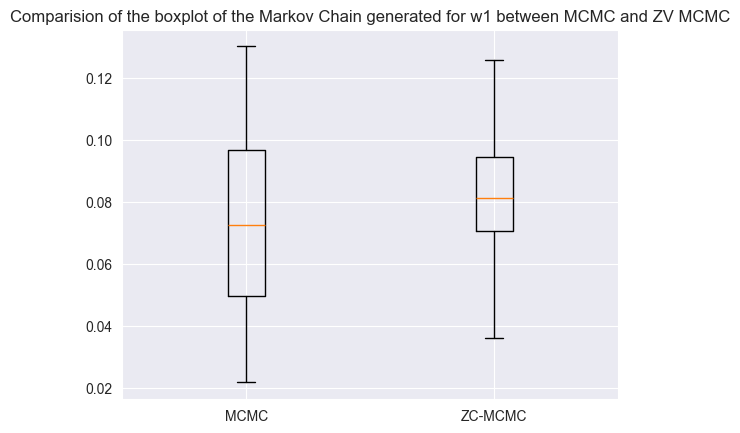

In [77]:
boxplot_comparison(w_tilde[0][:, 0], [sub_array[0] for sub_array in w1_results(w_tilde)[4]], 'w1')


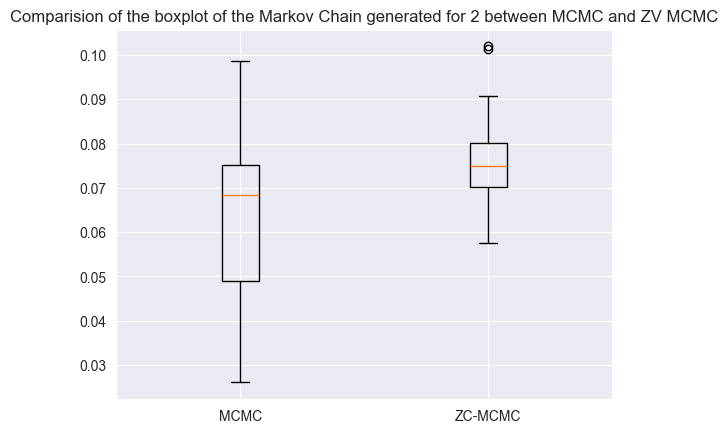

In [78]:
boxplot_comparison(w_tilde[0][:, 1], [sub_array[1] for sub_array in w2_results(w_tilde)[4]], '2')

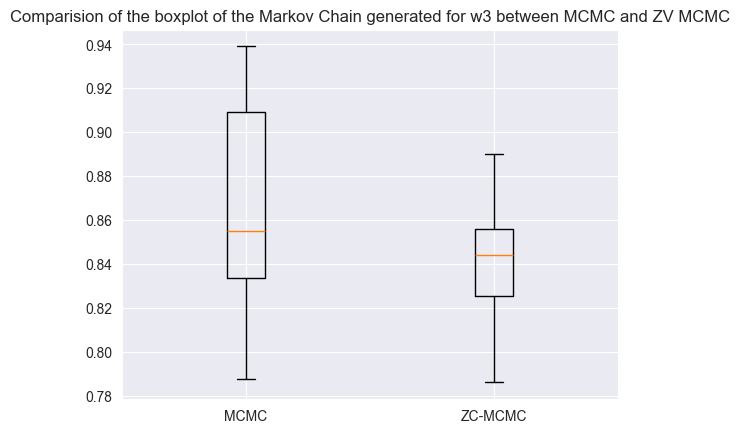

In [79]:
boxplot_comparison(w_tilde[0][:, 2], [sub_array[2] for sub_array in w3_results(w_tilde)[4]], 'w3')


As we can see, the results are even better than for the question 2.